# Introduction
Este notebook faz parte do trabalho de conclusão do curso (TCC) apresentado para obtenção do título de especialista no curso de Ciência de Dados e Big Data na PUC / Minas Gerais.

## Contextualização

O Airbnb é uma plataforma que foi criada em 2007. Seus criadores eram dois amigos que moravam juntos, precisavam de dinheiro, e se aproveitaram de uma oportunidade. Uma grande conferência de design estava acontecendo em São Francisco, onde moravam, e todos os hotéis locais estavam ocupados. Eles decidiram, então, criar a plataforma (que na época se chamava AirBedandBreakfast).</p>

Desde então, a plataforma cresceu significativamente e hoje em dia tem mais de 7 milhões de propriedades listadas, e está disponível em 100.000 cidades em 220 países. 

Essa plataforma cresceu tanto resolvendo um problema importante. O mesmo problema que levou os seus criadores a cria-la originalmente: Unir pessoas com espaço disponível querendo uma renda extra, e pessoas que precisam de um lugar para ficar, e não querem depender de hotéis. Seja por motivo de custo, disponibilidade ou praticidade.

Selecionar um imóvel com bom custo-benefício, entretanto, não é trivial. A plataforma oferece inúmeras opções de customização do anúncio, centenas de possíveis amenidades, descrição do anfitrião, diversas categorias de avaliação, o texto em si das avaliações, dentre outras. 

Esse excesso de atributos faz com que seja difícil, tanto para um anfitrião, quanto para um hóspede de tomar decisão. O anfitrião vai ter como interesse maximizar o lucro do seu imóvel ou espaço disponível, enquanto o hóspede tipicamente terá como interesse principal maximizar o custo-benefício de sua estadia.

## O Problema
Diante desse contexto, este estudo tem como objetivo determinar quais são os principais atributos que contribuem para o preço listado de uma propriedade no Airbnb, tão como criar um modelo de predição para esses preços. Para o estudo, a cidade de Toronto, em Ontario, foi selecionada. Toronto é uma cidade turística que recebe 27.5 milhões de visitantes anualmente, e é o principal destino turístico no Canada.

Para facilitar o entendimento do problema, este estudo inclui a técnica dos 5W’s, que consiste em fazer as seguintes perguntas:

- **Why?** Uma boa modelagem do preço permite a um potencial hóspede maximizar seu custo-benefício, e permite um potencial anfitrião maximizar seu lucro.


- **Who?** Parte dos dados foram coletados pela InsideAirbnb, e são referentes às propriedades listadas na plataforma Airbnb. A outra parte dos dados (geográficos) foram fornecidos pela plataforma Mapquest.

- **What?** São dois objetivos: Predizer o preço listado de um imóvel na plataforma Airbnb a partir destes atributos mais importantes e entender quais são os atributos mais importantes e o impacto destes

- **Where?** Imóveis de toda a cidade de Toronto, localizada na província de Ontário, no Canada.

- **When?** O banco de dados apresenta anúncios cadastrados de anfitriões que estão desde 2008 no Airbnb.


## Fontes de Dados

### Esse script precisa das seguintes fontes de dados:
>listings.csv

>reviews.csv (Indiretamente)

- Dados: Imóveis listados em Toronto, Ontario, na plataforma Airbnb em 08 de Fevereiro de 2021. Indexados pelo ID do anúncio.
- Fonte: Através da execução do script **download_airbnb.ipynb**, que faz download dos dados no site Insideairbnb.com.

>geolocation_data.csv
- Dados: Município dos imóveis listados em **listings.csv**, indexados pelo ID do anúncio.
- Fonte: Através da execução do script **GEO_process_coordinates.ipynb**, que usa o arquivo **listings.csv** como input, e a API do Mapquest para fornecer os dados de geolocalização reversa.

>processed_listing_descriptions_small.csv

>processed_listing_reviews_small.csv

- Dados: Análise de Subjetividade (PLN), com polaridade das descrições dos anúncios no **listings.csv** e **reviews.csv**, respectivamente.
- Fonte(descriptions): Através da execução do script **NLP_process_descriptions.ipynb**, que usa o arquivo **listings.csv** como input.
- Fonte(reviews): Através da execução do script **NLP_process_reviews.ipynb**, que usa o arquivo **reviews.csv** como input.

# 0 - Importing Libraries

In [1]:
#!pip3 install numpy
#!pip3 install pandas
#!pip3 install seaborn
#!pip3 install statsmodels
#!pip3 install xgboost

In [2]:
## Math + Charts + Stats
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from collections import Counter

# Geo Localization
import folium
from folium.plugins import FastMarkerCluster, HeatMap

# Images
from IPython import display

# Models + Metrics
from sklearn import preprocessing, linear_model, metrics
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import XGBRegressor

# Performance
from datetime import datetime
import time

warnings.filterwarnings('ignore')
%matplotlib inline

# 1 - Reading and Importing Data

## Definindo o PATH dos arquivos

In [3]:
# Files from external sources
file_toronto_listings = "../2-data/input/Toronto_2021-02-08/listings.csv"

# Files preprocessed by auxiliary scripts
file_processed_descriptions = '../2-data/generated/processed_listing_descriptions_small.csv' #NLP
file_processed_reviews      = '../2-data/generated/processed_listing_reviews_small.csv'      #NLP
file_geolocation_data       = "../2-data/generated/geolocation_data.csv"                     #Geo-localização

# Where figures will be saved (for report)
final_figures = '../3-report/figures/'

In [4]:
# Performance
start_time = time.time()

## Loading Airbnb listings in a pandas dataframe

In [5]:
# File should be generated by download_airbnb.ipynb
df = pd.read_csv(file_toronto_listings, index_col = 'id')

In [6]:
## Basic Configs (.ipynb)
pd.set_option('display.max_rows', 80) 
pd.set_option('display.max_columns', len(df.columns))

In [7]:
print(df.shape)

(15832, 73)


# 2 - Data Cleaning: Converting formats, Missing Values (N/A) and Feature Engineering

## Converting Data Types
### Converting: 'price', 'host_response_rate', "host_acceptance rate" → [Float]

In [8]:
# By Default, 'price' is not in numeric format, but string.
print(df["price"].head())
# Remove  $ from price column (e.g. $ 3,320.00 -> 3,320.00)
df["price"] = df["price"].str.replace('$', '')
# Remove ',' (e.g. $ 3,320.00 -> 3320.00)
df["price"] = df["price"].str.replace(',', '')
# Finally, convert to 'float' format
df["price"] = df["price"].astype(float)

id
1419     $469.00
8077      $96.00
23691     $72.00
27423     $45.00
30931    $128.00
Name: price, dtype: object


In [9]:
# Similarly, host_response_rate and host_acceptance_rate are also not numeric, by default.
df["host_response_rate"]   = df["host_response_rate"].str.replace('%', '').astype(float)
df["host_acceptance_rate"] = df["host_acceptance_rate"].str.replace('%', '').astype(float)

### Converting all boolean columns: "t" / "f" -> 1 / 0

In [10]:
df.replace({'f': 0, 't': 1}, inplace=True)

### Converting all Date Columns

In [11]:
df["host_since"] = pd.to_datetime(df["host_since"])
df["last_scraped"] = pd.to_datetime(df["last_scraped"])
df["first_review"] = pd.to_datetime(df["first_review"])
df["last_review"] = pd.to_datetime(df["last_review"])

## Feature Engineering: New columns from the date columns

In [12]:
# We'll calculate the number of days in relation to when data was obtained (last_scrapped) for all dates.
df['host_since_days']   = (df['last_scraped'] - df["host_since"])
df['first_review_days'] = (df['last_scraped'] - df["first_review"])
df['last_review_days']  = (df['last_scraped'] - df["last_review"])

# Converting to days precision (timedelta64[ns] -> timedelta64[D])
df['host_since_days']   = df['host_since_days'].astype('timedelta64[D]') 
df['first_review_days'] = df['first_review_days'].astype('timedelta64[D]') 
df['last_review_days']  = df['last_review_days'].astype('timedelta64[D]') 

In [13]:
df[['host_since_days','last_scraped','host_since']].head()

,host_since_days,last_scraped,host_since
id,,,
1419,4568.0,2021-02-09,2008-08-08
8077,4250.0,2021-02-09,2009-06-22
23691,3986.0,2021-02-11,2010-03-15
27423,3935.0,2021-02-10,2010-05-04
30931,4250.0,2021-02-09,2009-06-22


## Removing unused columns (Text, metadata, url)

In [14]:
# IDs and metadata of when data was obtained does not help the model. Listing ID is maintained, as this id DF's index.
# Text columns are removed HERE, but they are used in NLP processing script. (which is separate, to optimize performance)
# Geolocalization (neighbourhood) is also used in the geolocalization module (lat x lon), and therefore, removed here.
# Finally, URL does not contribute to the model and is removed.

text_cols = ['name', 'description', 'neighborhood_overview', 'host_name', 'host_location', 'host_about', 'host_neighbourhood', 'host_verifications', 'neighbourhood']
metadata_cols = ['scrape_id', 'last_scraped', 'calendar_last_scraped']
url_cols = ['listing_url', 'picture_url', 'host_url', 'host_thumbnail_url', 'host_picture_url']
drop_columns = text_cols + metadata_cols + url_cols

df.drop(drop_columns, axis=1, inplace=True)

# Performance
print ("Remoção a total of " + str(len(drop_columns)) + " columns.")

Remoção a total of 17 columns.


## Removing Columns: Availability = 0 (em 365 dias) + 0 totais - i.e. Out of the market properties / Properties for price espectulation / Paused listings

In [15]:
print("Um total de " + str(df.loc[(df['availability_365'] == 0) & (df['number_of_reviews'] == 0)].shape[0]) + " propriedades foram removidas.")
df.drop(df.loc[(df['availability_365'] == 0) & (df['number_of_reviews'] == 0)].index, inplace=True)

Um total de 1301 propriedades foram removidas.


## Processing host columns ('..._host_...')

### N/A Values (host_since_days): Removing Lines/Listings

In [16]:
## 15 properties has most of host columns completely missing. We could fill with median or such, but since 
## literally all columns are missing and they are not numerous (only 15), we will remove them.

print(df.loc[(df['host_since_days'].isna() == 1) & (df['host_since'].isna() == 1) & (df['host_response_time'].isna() == 1) & (df['host_response_rate'].isna() == 1) & (df['host_response_time'].isna() == 1) ].shape)
df.drop(df.loc[(df['host_since_days'].isna() == 1) & (df['host_response_time'].isna() == 1) & (df['host_response_rate'].isna() == 1)].index, inplace=True)

(15, 59)


### N/A Values (host_response_time): Filling and Categorizing (N/A = Never posted response)

In [17]:
# Amount of missing values: 5502. Here, missing values HAVE a meaning - they are hosts that have never posted 
# a response, since they never received a question.

print(df['host_response_time'].isna().sum()) #5502 valores em branco
df['host_response_time'].fillna('no response yet', inplace=True)
df['host_response_time'].value_counts()

5487


no response yet       5487
within an hour        5453
within a few hours    1671
within a day          1230
a few days or more     675
Name: host_response_time, dtype: int64

### Removing identical columns: calculated_host_listings_count, host_listings_count and host_total_listings_count

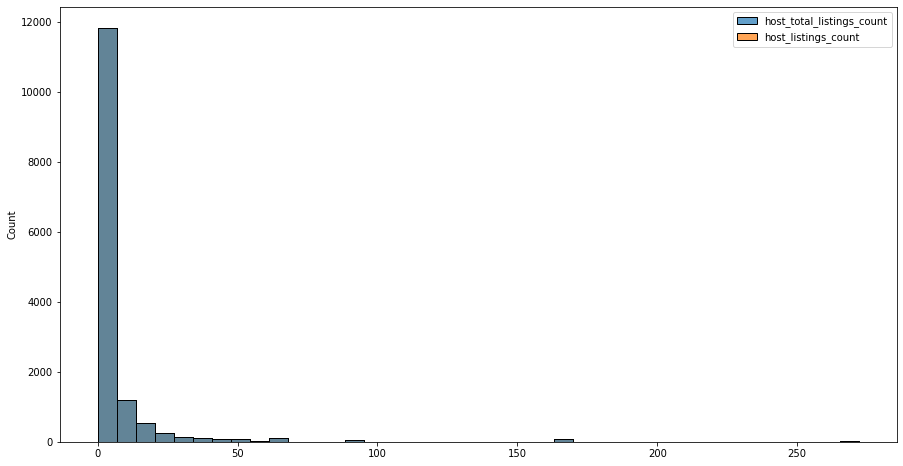

In [18]:
# host_listings_count is equal to host_total_listings_count. Therefore, we only need one of them.
# Those columns, however, also consider property OUTSIDE of toronto (i.e. in other countries).
# On the other hand, calculated_host_listings_count has EXCLUSIVELY properties in toronto.
# Because of this, we will use only the last one, and remove the first two.

plt.figure(figsize=(15,8))
sns.histplot([df["host_total_listings_count"],df["host_listings_count"]], multiple='dodge', alpha=0.7, bins=40)

df.drop("host_total_listings_count", axis=1, inplace=True)
df.drop("host_listings_count", axis=1, inplace=True)


### Removing calculated columns ("calculated_host_listings_count_entire_homes", "..._private_rooms", "..._sharedrooms")

In [19]:
# Insideairbnb supplies many already-calculated columns, by pre-processing host_listings_count and property_type.
# We will drop those columns, since we will do the processing ourselves.

drop_columns = ["calculated_host_listings_count_entire_homes", "calculated_host_listings_count_private_rooms", "calculated_host_listings_count_shared_rooms"]
df.drop(drop_columns, axis=1, inplace=True)

### Removing columns with more than 90% of data in a single category ('host_has_profile_pic', 'has_availability')

1.0    14475
0.0       41
Name: host_has_profile_pic, dtype: int64
1    14292
0      224
Name: has_availability, dtype: int64


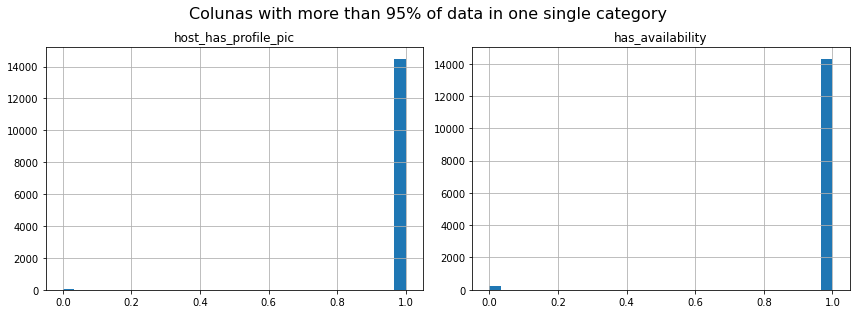

In [20]:
# The following columns are very similar. Because of this, we will select only two (maximum_nights, minimum_nights),
# and remove all others - minimizing data colinearity.

print(df["host_has_profile_pic"].value_counts()) #14475 values are 1.0 (>90%)
print(df["has_availability"].value_counts()) #14292 values are 1.0 (>90%)

one_sided_columns = ['host_has_profile_pic','has_availability']
sub_title = 'Colunas with more than 95% of data in one single category'

fig = plt.figure(figsize=(12,8))
for i, var_name in enumerate(one_sided_columns):
    fig.suptitle(sub_title, fontsize=16)
    ax = fig.add_subplot(2,2,i+1)
    df[var_name].hist(bins=30,ax=ax)
    
    ax.set_title(var_name)
fig.tight_layout()
plt.show()

df.drop(['has_availability', 'host_has_profile_pic'], axis=1, inplace=True)
#fig.savefig(final_figures+"one_category.jpeg",format='jpeg', dpi=300)

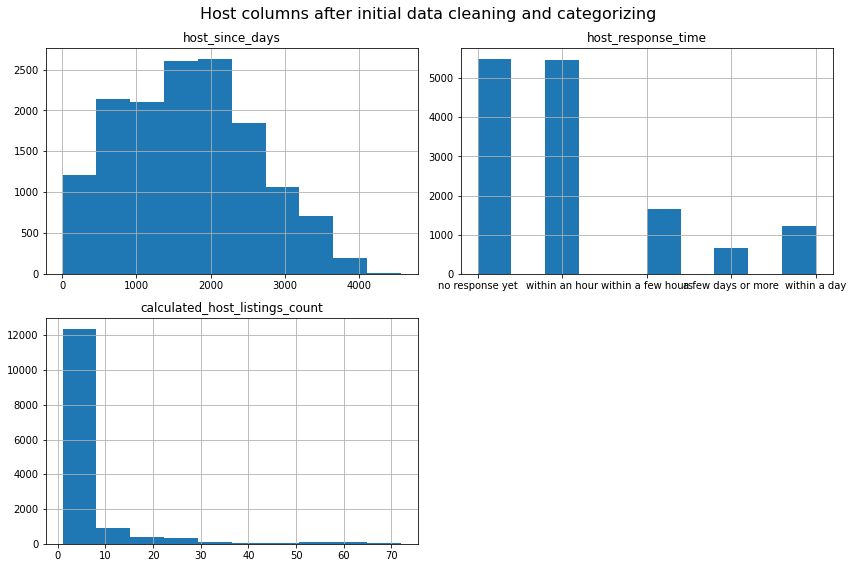

In [21]:
host_columns = ['host_since_days','host_response_time','calculated_host_listings_count']
sub_title = 'Host columns after initial data cleaning and categorizing'

fig = plt.figure(figsize=(12,8))
for i, var_name in enumerate(host_columns):
    fig.suptitle(sub_title, fontsize=16)
    ax = fig.add_subplot(2,2,i+1)
    df[var_name].hist(ax=ax)
    ax.set_title(var_name)    
fig.tight_layout()

plt.show()
#fig.savefig("host_columns.jpeg",format='jpeg', dpi=300)

### Data Engineering: Categorizing host_response_rate and host_acceptance_rate in bins

In [22]:
# 5487 missing values (N/A). We will treat both of those as categoricals.
# Since they are BOTH numericals, we will need to bin them.
print(df['host_response_rate'].isna().sum())
print(df['host_acceptance_rate'].isna().sum())

5487
3978


In [23]:
# Creating the bins
df['host_response_rate'] = pd.cut(df['host_response_rate'], 
                               bins=[0, 60, 91, 99, 100], 
                               labels=['0-60%', '60-91%', '90-99%', '100%'], 
                               include_lowest=True)

# Converting in string, and substituing N/As for Categoricals
df['host_response_rate'] = df['host_response_rate'].astype('str')
df['host_response_rate'].fillna('no response yet', inplace=True)

# Category counts
df['host_response_rate'].value_counts()


100%               6269
no response yet    5487
60-91%             1103
0-60%               897
90-99%              760
Name: host_response_rate, dtype: int64

In [24]:
# Creating the bins
df['host_acceptance_rate'] = pd.cut(df['host_acceptance_rate'], 
                               bins=[0, 74, 92, 99, 100], 
                               labels=['0-74%', '74-92%', '92-99%', '100%'], 
                               include_lowest=True)

# Converting in string, and substituing N/As for Categoricals
df['host_acceptance_rate'] = df['host_acceptance_rate'].astype('str')
df['host_acceptance_rate'].fillna('no response yet', inplace=True)

# Category counts
df['host_acceptance_rate'].value_counts()

no response yet    3978
100%               3262
92-99%             2641
74-92%             2399
0-74%              2236
Name: host_acceptance_rate, dtype: int64

## Removing columns with a high number of missing values (>70%).

In [25]:
# Columns with a high number of missing values
isNAdf = pd.DataFrame({'column_name':df.isna().sum().index, 'Sum_NA':df.isna().sum().values, "Percent_NA":(df.isna().sum().values/df.shape[0]*100)})

# Filter for columns with >70% missing data
drop_columns = isNAdf[isNAdf.Percent_NA > 70]["column_name"]
df.drop(drop_columns, axis=1, inplace=True)

print("Dropping a total of " + str(len(drop_columns)) + " columns.")
print(isNAdf[isNAdf.Percent_NA > 70])

Dropping a total of 4 columns.
                     column_name  Sum_NA  Percent_NA
8   neighbourhood_group_cleansed   14516  100.000000
14                     bathrooms   14516  100.000000
28              calendar_updated   14516  100.000000
45                       license   10774   74.221549


## Columns related to the property itself: availability, property_type, room_type, bathrooms, beds, bedrooms and amenities)

### Removing redundant columns: Minimum / maximum available nights

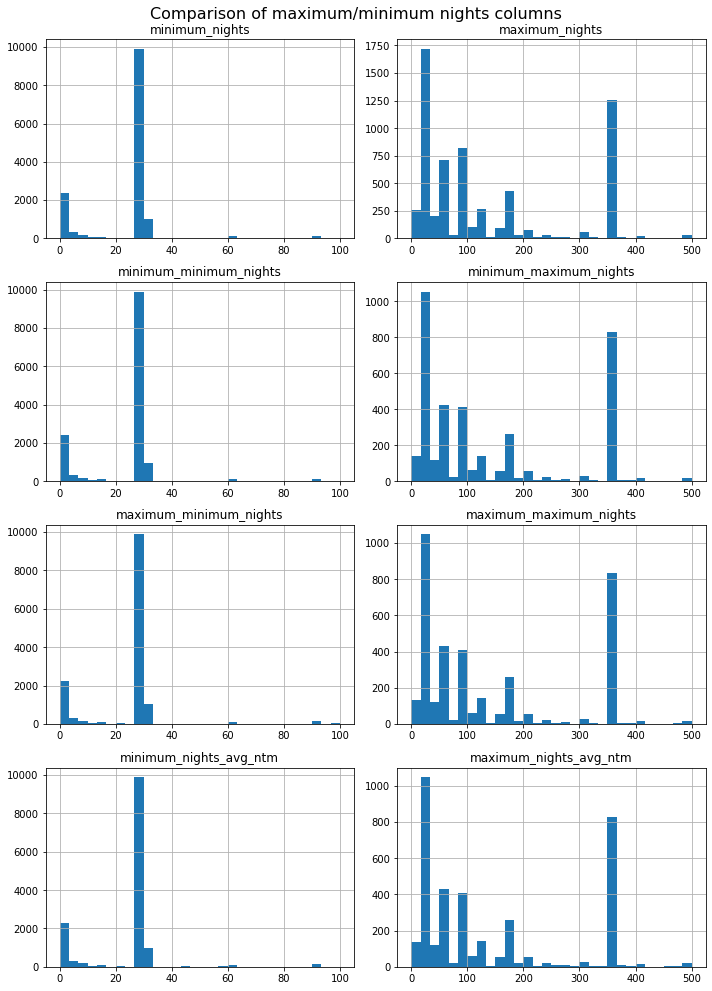

In [26]:
# There are 8 columns to describe the maximum and minimum nights, but they are extremely redundant (see the histograms below)
# Because of this, we will only use 2 of those 8 columns, to minimize colinearity.

nights_columns=['minimum_nights','maximum_nights','minimum_minimum_nights', 'minimum_maximum_nights', 'maximum_minimum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm']

sub_title = 'Comparison of maximum/minimum nights columns'

fig = plt.figure(figsize=(10,14))
for i, var_name in enumerate(nights_columns):
    fig.suptitle(sub_title, fontsize=16)
    ax = fig.add_subplot(4,2,i+1)
    # For maximum_... we use 500 as a range
    if (i%2):
        df[var_name].hist(bins=30,ax=ax, range=(0,500))
    # For minimum_...we use 100 as range
    else:
        df[var_name].hist(bins=30,ax=ax, range=(0,100))
    
    ax.set_title(var_name)
fig.tight_layout()
plt.show()

df.drop(['minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm'], axis=1, inplace=True)

#fig.savefig("noites_maximas.jpeg",format='jpeg', dpi=300)

### Removing redundant columns: availability

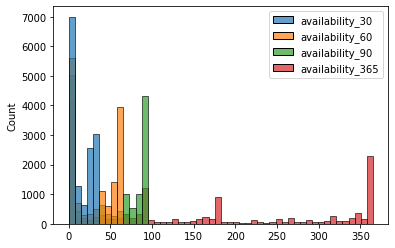

In [27]:
# Once again, availability_365 has more data than all the other columns, so well keep just it.
count_available_30d = (df['availability_30'] != 0).sum()
count_available_60d = (df['availability_60'] != 0).sum()
count_available_90d = (df['availability_90'] != 0).sum()
count_available_365d = (df['availability_365'] != 0).sum()
figure=sns.histplot([df["availability_30"],df["availability_60"],df["availability_90"],df["availability_365"]], multiple='dodge', alpha=0.7, bins=50)
df.drop(['availability_30', 'availability_60', 'availability_90'], axis=1, inplace=True)

#figure.figure.savefig("availability.jpeg",format='jpeg', dpi=300)

### Feature Engineering: Re-categorizing property_type

In [28]:
# Note that we have 2 RVs and 3 Boats
print(df['property_type'].nunique())
df['property_type'].value_counts()

61


Entire condominium                    3477
Entire apartment                      2963
Private room in house                 2362
Entire house                          1487
Private room in apartment              896
Entire guest suite                     613
Private room in condominium            506
Private room in townhouse              376
Private room in bungalow               335
Entire townhouse                       272
Entire loft                            241
Entire bungalow                        179
Private room in guest suite            119
Room in boutique hotel                  83
Shared room in house                    80
Private room in villa                   64
Private room in guesthouse              48
Shared room in apartment                45
Entire guesthouse                       45
Room in hotel                           39
Shared room in condominium              35
Private room in bed and breakfast       30
Shared room in townhouse                29
Entire serv

In [29]:
# We will manually categorize all of those:
df['property_type'].replace({
"Entire condominium"                : "Apartment",
"Entire apartment"                  : "Apartment",
"Private room in house"             : "House",
"Entire House"                      : "House",
"Private room in apartment"         : "Apartment",
"Entire guest suite"                : "Apartment",
"Private room in condominium"       : "Apartment",
"Private room in townhouse"         : "House",
"Private room in bungalow"          : "House",
"Entire townhouse"                  : "House",
"Entire loft"                       : "Apartment",
"Entire bungalow"                   : "House",
"Private room in guest suite"       : "Apartment",
"Shared room in house"              : "House",
"Room in boutique hotel"            : "Hotel",
"Private room in villa"             : "House",
"Shared room in apartment"          : "Apartment",
"Private room in guesthouse"        : "House",
"Entire guesthouse"                 : "House",
"Room in hotel"                     : "Hotel",
"Shared room in condominium"        : "Apartment",
"Entire serviced apartment"         : "Apartment",
"Shared room in townhouse"          : "House",
"Private room in loft"              : "Apartment",
"Room in hostel"                    : "Hotel",
"Entire villa"                      : "House",
"Private room in serviced apartment": "Apartment",
"Room in aparthotel"                : "Hotel",
"Shared room in tiny house"         : "House",
"Shared room in bungalow"           : "House",
"Private room in tiny house"        : "House",
"Tiny house"                        : "House",
"Private room in hostel"            : "Hotel",
"Private room in cottage"           : "House",
"Entire cottage"                    : "House",
"Entire house"                      : "House",
}, inplace = True)
df.loc[~df.property_type.isin(['House', 'Apartment', "Hotel"]), 'property_type'] = 'Other'

In [30]:
# Creating a new count and adding a % total
propertyTypesSeries = df['property_type'].value_counts()
propertyTypesdf = pd.DataFrame({'Property Type':propertyTypesSeries.index, 'Quantity':propertyTypesSeries.values, "Fraction of total":(propertyTypesSeries.values/df.shape[0]*100)})
propertyTypesdf

,Property Type,Quantity,Fraction of total
0,Apartment,8950,61.656104
1,House,5325,36.683659
2,Hotel,161,1.109121
3,Other,80,0.551116


### room_type analysis

In [31]:
# Creating a new count and adding a % total
roomTypesSeries = df.room_type.value_counts()
roomTypesdf = pd.DataFrame({'Room_type':roomTypesSeries.index, 'Quantity':roomTypesSeries.values, "Fraction of Total":(roomTypesSeries.values/df.shape[0]*100)})
roomTypesdf

,Room_type,Quantity,Fraction of Total
0,Entire home/apt,9349,64.404795
1,Private room,4912,33.838523
2,Shared room,210,1.446680
3,Hotel room,45,0.310003


### Missing Values (N/A): Removal and Categorization

In [32]:
# Note that, according to Airbnb, "Half bathroom" (0.5) means a bathroom with only toilet and sink (i.e. no tub or shower)
# https://community.withairbnb.com/t5/Help/Meaning-of-Indicating-bathroom-as-1-or-0-5/td-p/105155

print(df['bathrooms_text'].value_counts())


# Categorizing ouselves all half-baths to 0.5
df['bathrooms_text'].replace({
"Shared half-bath"                  : 0.5,
"Private half-bath"                 : 0.5,
"half-bath"                         : 0.5,
"Half-bath"                         : 0.5,
}, inplace = True)

1 bath               7282
1 shared bath        2388
2 baths              1573
1 private bath       1219
1.5 baths             623
1.5 shared baths      356
2 shared baths        336
2.5 baths             225
3 baths               170
3.5 baths              64
3 shared baths         56
2.5 shared baths       44
4 baths                30
4.5 baths              26
0 shared baths         21
0 baths                17
Shared half-bath       14
3.5 shared baths       13
5 baths                 9
Half-bath               8
Private half-bath       6
6 baths                 5
6.5 baths               4
5.5 baths               4
4 shared baths          4
4.5 shared baths        1
5 shared baths          1
7.5 baths               1
12 baths                1
Name: bathrooms_text, dtype: int64


In [33]:
# Extracting number of bathrooms. We won't categorize the bathroom as shared-bath or private-bath, this would segment data too much.
# Additionally, the shared or private data is already contaiend in the room_type, so this could cause colinarity issues.

df['bathrooms_text'] = df['bathrooms_text'].str.extract('(\d+.\d?)')
df['bathrooms_text'].astype('float64')

df["bathrooms_text"].isna().sum() #43
df.dropna(subset=['bathrooms_text'], inplace=True)
df['bathrooms_text']=df['bathrooms_text'].astype('float64')


### N/A values ('Beds' & 'bedrooms'): median fill

In [34]:
print(df['beds'].isna().sum()) #168
print(df['bedrooms'].isna().sum()) #1100

df['beds'].fillna(df['beds'].median(), inplace=True)
df['bedrooms'].fillna(df['bedrooms'].median(), inplace=True)

168
1100


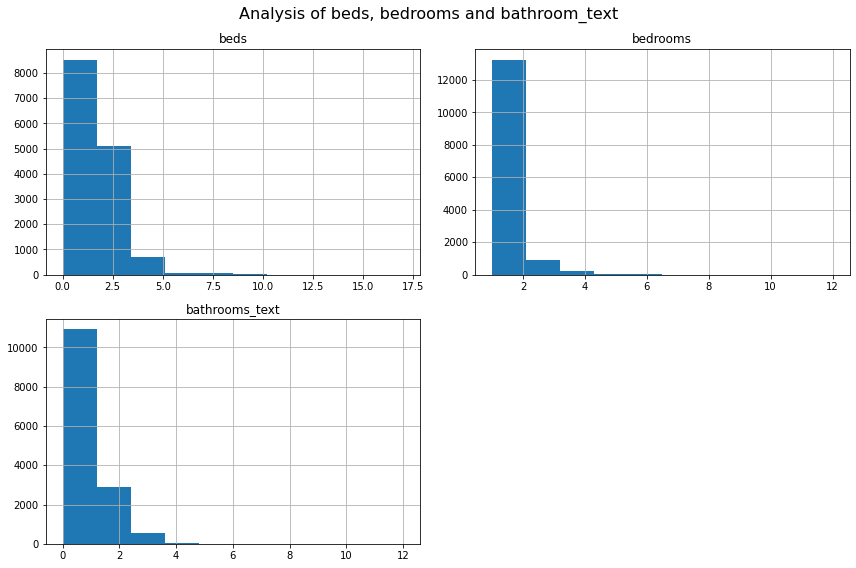

In [35]:
# Checking data distribution of the previous columns
processed_columns = ['beds', 'bedrooms', 'bathrooms_text']
sub_title = "Analysis of beds, bedrooms and bathroom_text"

fig = plt.figure(figsize=(12,8))
for i, var_name in enumerate(processed_columns):
    fig.suptitle(sub_title, fontsize=16)
    ax = fig.add_subplot(2,2,i+1)
    df[var_name].hist(ax=ax)
    ax.set_title(var_name)
fig.tight_layout()
plt.show()

#fig.savefig(final_figures+"Imoveis.jpeg",format='jpeg', dpi=300)

### Feature Engineering: Categorizing Amenities 

In [36]:
# To deal with amenities, we will need to process the text which starts as big lists ['Amenity A', 'Amenity B', 'Amenity C']

# Creating a list that contains all amenities
amenities_list = " ".join(list(df.amenities))
amenities_list = amenities_list.replace('{', '').replace('}', ',')
amenities_list = amenities_list.replace('[', '').replace(']', ',')
amenities_list = amenities_list.replace('"', '')

# Fixing a few text importing issues / artifacts.
# For example: \u2019s means ' (e.g. "Children\u2019s dinnerware" → "Children's dinnerware"). 
# \u2019n means /.
# \ means inches (e.g. 12 \ TV → 12 inches TV).
amenities_list = amenities_list.replace('\\u2019s', '`')
amenities_list = amenities_list.replace('\\u2019n', '/')
amenities_list = amenities_list.replace('\\', ' inches')
#print(amenities_list).

# Finally, we will split and categorize by frequency. We will then, 
# only keep the first 44 amenities (at least 2200 cases)
my_list = amenities_list.split(", ")
print(len(my_list)) #378.502 amenities on total
#Counter(my_list).most_common()[0:43]

378502


In [37]:
# Creating boolean columns, one for each amenity. Note that the amenities are intentionally named 
# with the prefix am_, to faciltiate identification later on.
# Ex: "am_TV", "am_microwave"

for x in range(43):
    amenityName = Counter(my_list).most_common()[x][0]
    df.loc[df['amenities'].str.contains(amenityName), 'am_' + amenityName] = 1
    #NOTE: Commented to save time, but useful for debugging
    #print ("Column "+ amenityName + " Added. This column has " + str(Counter(my_list).most_common()[x][1]) + " occurrencies (" + str(round((Counter(my_list).most_common()[x][1]/401040)*100)) + "% of total)")
    # Missing values here are simply listings without a particular amenity
    df['am_' + amenityName].fillna(0, inplace = True) 

# Now that we created one column for each amenity, we can remove the initial one.
df.drop(["amenities"], axis=1, inplace=True)

## Columns related to reviews (first_, last_reviews, review_scores, review_number)

### Missing values: Categorizing in bins first_review_days and last_review_days

<AxesSubplot:ylabel='Count'>

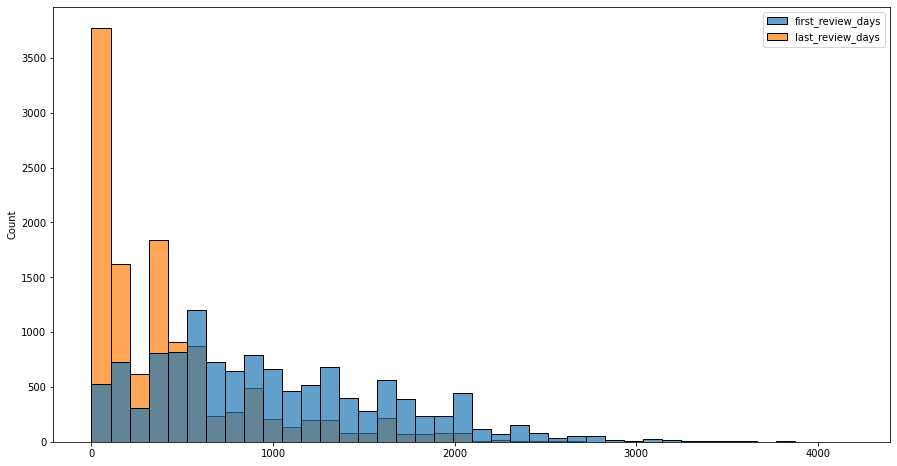

In [38]:
plt.figure(figsize=(15,8))
sns.histplot([df["first_review_days"],df["last_review_days"]], multiple='dodge', alpha=0.7, bins=40)

In [39]:
print(df['first_review_days'].isna().sum())
print(df['last_review_days'].isna().sum())

2361
2361


In [40]:
# Creating bins, just like we did for host_response_rate
df['first_review_days'] = pd.cut(df['first_review_days'], 
                        bins=[0, 365/2, 365, 365*2, 365*4, max(df['first_review_days'])],
                        labels=['0-6 months',
                                '6-12 months',
                                '1-2 years',
                                '2-4 years',
                                '4+ years'],
                               include_lowest=True)

df['first_review_days'] = df['first_review_days'].astype('str')
df['first_review_days'].fillna('no review yet', inplace=True)
df['first_review_days'].value_counts()

2-4 years        4186
1-2 years        3173
4+ years         2816
no review yet    2361
0-6 months       1080
6-12 months       857
Name: first_review_days, dtype: int64

In [41]:
# Creating bins, just like we did for host_response_rate
df['last_review_days'] = pd.cut(df['last_review_days'], 
                        bins=[0, 365/2, 365, 365*2, 365*4, max(df['last_review_days'])],
                        labels=['0-6 months',
                                '6-12 months',
                                '1-2 years',
                                '2-4 years',
                                '4+ years'],
                               include_lowest=True)

df['last_review_days'] = df['last_review_days'].astype('str')
df['last_review_days'].fillna('no review yet', inplace=True)
df['last_review_days'].value_counts()

0-6 months       5139
1-2 years        2672
no review yet    2361
6-12 months      2052
2-4 years        1599
4+ years          650
Name: last_review_days, dtype: int64

### Reviews: Scores

2550


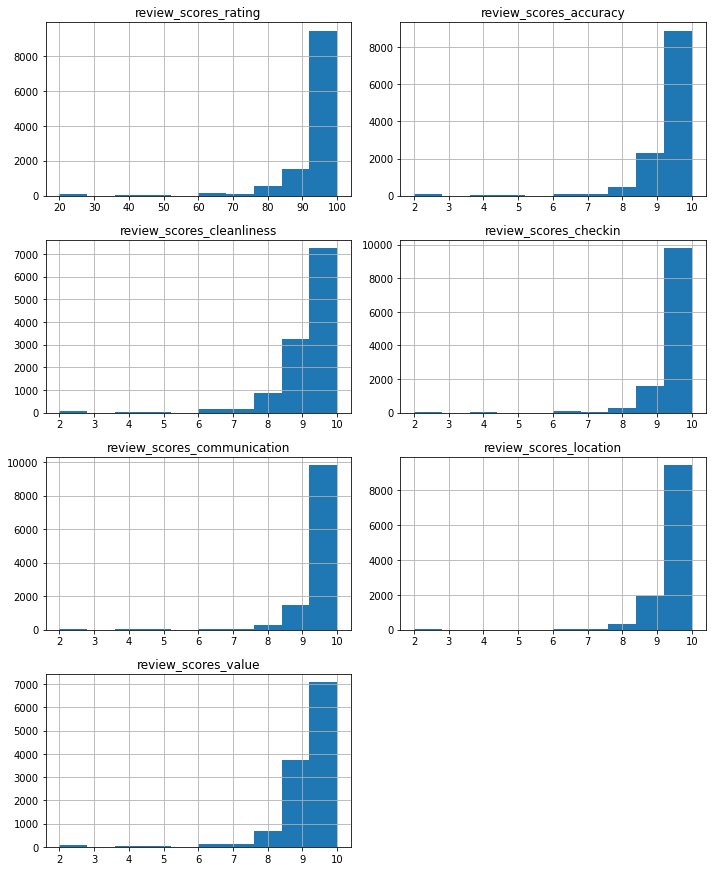

In [42]:
print(df['review_scores_rating'].isna().sum())

# Checking the distributions of the review ratings columns
review_columns = list(df.columns[df.columns.str.startswith("review_scores") == True])
fig = plt.figure(figsize=(10,18))
for i, var_name in enumerate(review_columns):
    ax = fig.add_subplot(6,2, i+1)
    df[var_name].hist(bins=10,ax=ax)
    ax.set_title(var_name)
fig.tight_layout()
plt.show()

#fig.savefig(final_figures+"dist_primeiras_review_scores.jpeg",format='jpeg', dpi=300)

In [43]:
# We will remove review_score_ratings, since its simply the sum of all other columns. We will consider each column directly.
df = df.drop("review_scores_rating", axis=1)

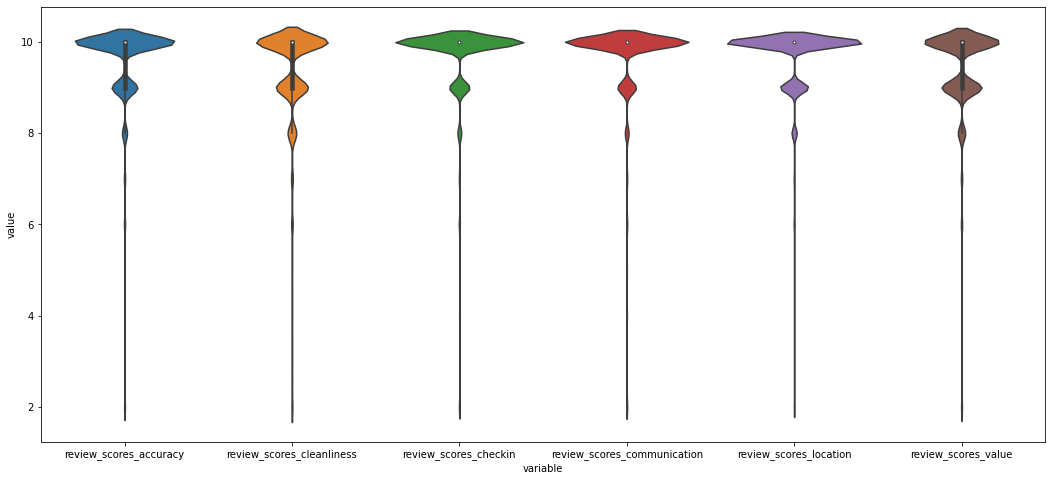

In [44]:
# Note how all reviews are strongly positively skewed (values 8, 9, 10)
# To do the violin plot, we will first need to melt the columns
melted_df = df.copy()
melted_df = pd.melt(melted_df[['review_scores_accuracy','review_scores_cleanliness','review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value']])
melted_df

plt.figure(figsize=(18,8))
sns.violinplot(x="variable", y="value", data=melted_df)

del melted_df # Dropping to optimize memory usage

In [45]:
# Creating bins, same procedure as host_response_rate
for col in ['review_scores_accuracy','review_scores_cleanliness','review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value']:
    df[col] = pd.cut(df[col],
                bins=[0, 5, 8, 9, 10],
                labels=['0-5','5-8', '8-9', '10'],
                include_lowest=True)

    df[col] = df[col].astype('str')
    df[col].fillna('no review yet', inplace=True)

In [46]:
# Checking distributions after binning
for col in ['review_scores_accuracy','review_scores_cleanliness','review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value']:
    print(df[col].value_counts())
    df[col].value_counts()

10               8872
no review yet    2582
8-9              2271
5-8               632
0-5               116
Name: review_scores_accuracy, dtype: int64
10               7269
8-9              3258
no review yet    2580
5-8              1206
0-5               160
Name: review_scores_cleanliness, dtype: int64
10               9807
no review yet    2582
8-9              1564
5-8               435
0-5                85
Name: review_scores_checkin, dtype: int64
10               9849
no review yet    2581
8-9              1493
5-8               448
0-5               102
Name: review_scores_communication, dtype: int64
10               9458
no review yet    2582
8-9              1925
5-8               457
0-5                51
Name: review_scores_location, dtype: int64
10               7101
8-9              3742
no review yet    2582
5-8               915
0-5               133
Name: review_scores_value, dtype: int64


### Reviews: Remoção de colunas inter-correlacionadas 
### Reviews: Removing redundant columns (drop number_of_reviews_ltm and reviews_per_l30d, keep reviews_per_month and number_of_reviews)

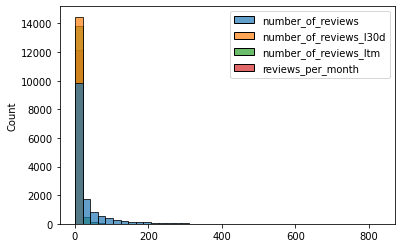

In [47]:
# "number_of_reviews_ltm" e "reviews_per_l30d" columns are temporary, respectively for the last 12 months reviews and last month reviews.
# We will remove them both, and keep the absolute ones (reviews_per_month and number_of_reviews)

ax = sns.histplot(df[['number_of_reviews','number_of_reviews_l30d', 'number_of_reviews_ltm', 'reviews_per_month']], multiple='dodge', alpha=0.7, bins=40)
df.drop(['number_of_reviews_ltm', 'number_of_reviews_l30d'], axis=1, inplace=True)

#ax.figure.savefig(final_figures+"hist_num_reviews.jpeg",format='jpeg', dpi=300)

### Treating missing values

In [48]:
# Once again, missing values indicate something. In this case, its that the property has not had a review yet.

df['reviews_per_month'].isna().sum()
df['reviews_per_month'].fillna(0, inplace=True)

## Removing Outliers: 'price' column

279
92.0
13000.0


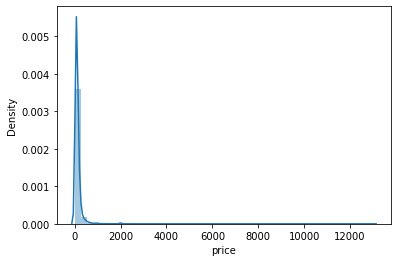

In [49]:
# Price data is extremely positively skewed. 
# 14194 listings have a price of ≤ CAD$500, and 317 (2% of total) have a price ≥ CAD$500

ax = sns.distplot(df['price'])

print(df.loc[df.price >= 501].count()['price'])
print(df.price.median())
print(df.price.max())

df.drop(df[df.price >= 500].index, inplace=True)
#ax.figure.savefig(final_figures+"hist_price_before.jpeg",format='jpeg', dpi=300)

In [50]:
# After removing the outliers, its much easier to interpret the price distribution.
# It is still positively skewed, but in a smaller range.
# Interesting to note how prices concentrate in certain psychological ranges (200, 250, 300, 350, 400, ...)

ax=sns.distplot(df['price'])
#ax.figure.savefig(final_figures+"hist_price_after.jpeg",format='jpeg', dpi=300)

## NLP

### NLP: processed_listing_reviews.csv → review_polarity

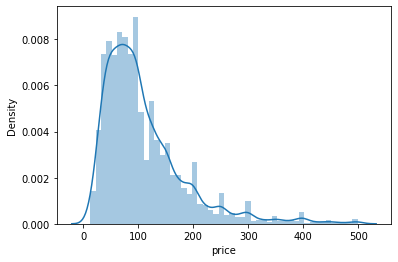

,review_polarity
listing_id,
16442542,0.9975
10428248,0.9972
36349569,0.9972
44162148,0.9966
43147441,0.9965


In [51]:
processed_reviews = pd.read_csv(file_processed_reviews, index_col = 'listing_id')
processed_reviews.head()

In [52]:
# Before concatenating the dataframes, we will check if 'processed_reviews' has any property id that 'df' doesnt have.
# In case that happens, we will remove those lines, since they would not have ANY other information, beside polarity
differentProperties = processed_reviews.index.difference(df.index)
print(len(differentProperties))
# Removing the indexes
processed_reviews = processed_reviews[~processed_reviews.index.isin(differentProperties)]

257


In [53]:
print(df.shape)
# Verifying integrity to avoid duplicating
df = pd.concat([df, processed_reviews], axis=1, verify_integrity=True)

# Confirming original shape was maintained, with the addition of one column
print(processed_reviews.shape)
print(df.shape)

(14156, 78)
(11896, 1)
(14156, 79)


array([[<AxesSubplot:title={'center':'review_polarity'}>]], dtype=object)

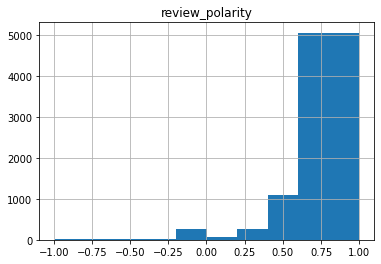

In [54]:
processed_reviews.hist()

### Feature Engineering: Categorizing in bins

In [55]:
# Bin into four categories
df['review_polarity'] = pd.cut(df['review_polarity'], 
                               bins=[-1, 0.65, 0.77, 0.85, 1], 
                               labels=['- 65%', '65-77%', '77-85%', '85% +'], 
                               include_lowest=True)

df["review_polarity"].value_counts()

65-77%    3179
85% +     3112
77-85%    3073
- 65%     2532
Name: review_polarity, dtype: int64

### NLP: processed_listing_descriptions.csv → description_polarity

In [56]:
processed_descriptions = pd.read_csv(file_processed_descriptions, index_col = 'id')
processed_descriptions.head()

,description_polarity
id,
2979246,0.9979
26662976,0.9977
39058638,0.9976
3849103,0.9970
21764678,0.9970


In [57]:
processed_descriptions.isna().sum()

description_polarity    0
dtype: int64

In [58]:
# Before concatenating the dataframes, we will check if 'processed_descriptions' has any property id that 'df' doesnt have.
# In case that happens, we will remove those lines, since they would not have ANY other information, beside polarity
differentProperties = processed_descriptions.index.difference(df.index)
print(len(differentProperties))
processed_descriptions = processed_descriptions[~processed_descriptions.index.isin(differentProperties)]

1580


In [59]:
# Verifying integrity to avoid duplicating
print(df.shape)
df = pd.concat([df, processed_descriptions], axis=1, verify_integrity=True)

# Confirming original shape was maintained, with the addition of one column
print(processed_descriptions.shape)
print(df.shape)

(14156, 79)
(13687, 1)
(14156, 80)


In [60]:
df['description_polarity'].isna().sum() #484 NA's
df['description_polarity'].fillna(df['description_polarity'].median(), inplace=True)

<AxesSubplot:>

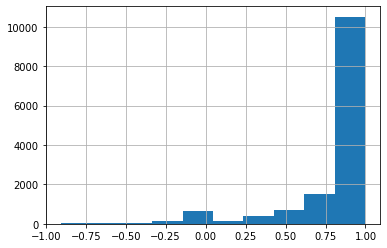

In [61]:
df['description_polarity'].hist()

In [62]:
len(df['neighbourhood_cleansed'])

14156

## Geolocation Data

140


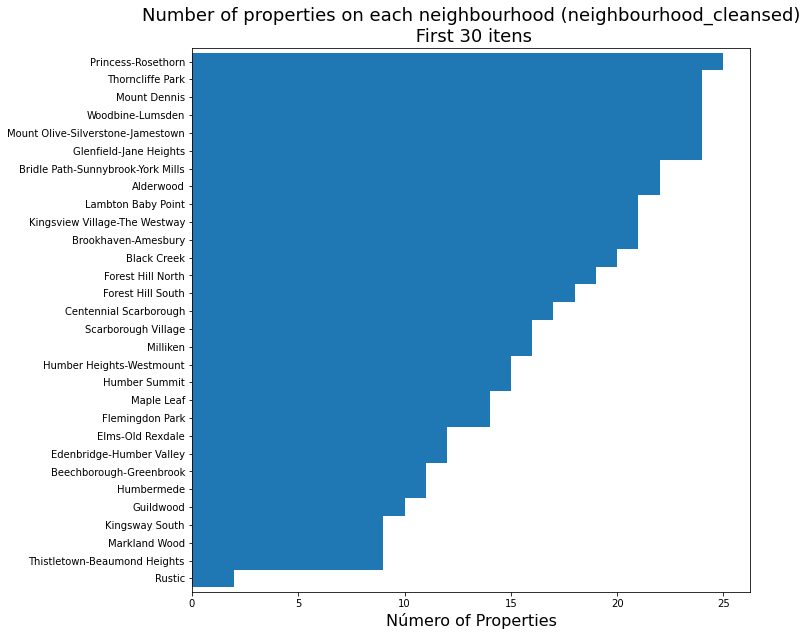

In [63]:
## We can't use the original 'neighbourhood_cleansed' because it has too many unique and segmented values. The most frequent item has only 26 occurrencies.
## Similarly, there's no neighbourhood column. Therefore, we will create this data.

print(df['neighbourhood_cleansed'].nunique())
freq = df['neighbourhood_cleansed'].value_counts().sort_values(ascending=True)
ax=freq[0:30].plot.barh(figsize=(10,10), width= 1)
plt.title('Number of properties on each neighbourhood (neighbourhood_cleansed)\n First 30 itens', fontsize=18)
plt.xlabel('Número of Properties', fontsize = 16)
plt.show()

df.drop('neighbourhood_cleansed', axis=1, inplace=True)

#ax.figure.savefig(final_figures+"neighbourhood_cleansed.jpeg",format='jpeg', dpi=300, bbox_inches='tight')

In [64]:
# Latitude and longitude are processed, independently, by geolocation_process_coordinates.ipynb.
# After processed, one neighbourhood is determined for each latitude-longitude pair, which is then read now.

geolocation_df = pd.read_csv(file_geolocation_data, index_col = 'listing_id')
geolocation_df = geolocation_df.rename(columns={'City': 'geo_city', 'County': 'geo_county', 'Neighborhood': 'geo_neighborhood'})
# We will remove county (It's Toronto for everybody), and remove geo_neighbourhood, since its empty.
geolocation_df = geolocation_df.drop(['geo_county', 'geo_neighborhood'], axis=1)

print(geolocation_df.shape)
geolocation_df.head()

(15832, 1)


,geo_city
listing_id,
1419,Toronto
8077,Toronto
23691,York
27423,Toronto
30931,Toronto


In [65]:
# Confirming indexes are not duplicated
print(geolocation_df.index.duplicated().sum())

# Before concatenating the dataframes, we will check if 'geolocation_df' has any property id that 'df' doesnt have.
# In case that happens, we will remove those lines, since they would not have ANY other information, beside polarity
differentProperties = geolocation_df.index.difference(df.index)
print(len(differentProperties))
geolocation_df = geolocation_df[~geolocation_df.index.isin(differentProperties)]

0
1676


In [66]:
# Verifying integrity to avoid duplicating
print(df.shape)
df = pd.concat([df, geolocation_df], axis=1, verify_integrity=True)

# Confirming original shape was maintained, with the addition of one column
print(geolocation_df.shape)
print(df.shape)

(14156, 79)
(14156, 1)
(14156, 80)


0


<AxesSubplot:>

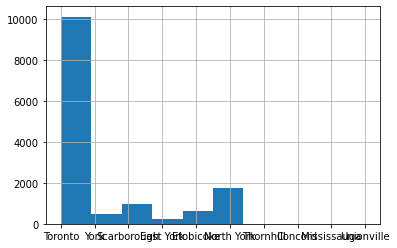

In [67]:
print(df['geo_city'].isna().sum())
df['geo_city'].hist()

In [68]:
# Removing listings that are in neighbourhoods with less than 2 cases.
# They wouldn't help with data processing, understanding or with the model.

df.drop(df.loc[df['geo_city'] == 'Unionville'].index, inplace=True) # 2
df.drop(df.loc[df['geo_city'] == 'Thornhill'].index, inplace=True) # 2
df.drop(df.loc[df['geo_city'] == 'Mississauga'].index, inplace=True) # 1
df.drop(df.loc[df['geo_city'] == 'Concord'].index, inplace=True) # 1

# We will also substitute 'Toronto' to 'Old Toronto' since this is, technically, the neighbourhood name.
df['geo_city'] = df['geo_city'].str.replace('Toronto','Old Toronto')

print(df['geo_city'].value_counts())

Old Toronto    10129
North York      1758
Scarborough      945
Etobicoke        612
York             463
East York        243
Name: geo_city, dtype: int64


In [69]:
# Creating 8 clusters using k-means clustering algorithm.
kmeans = KMeans(8)
clusters = kmeans.fit_predict(df[['latitude','longitude']])
df['geo_cluster'] = kmeans.predict(df[['latitude','longitude']])

In [70]:
df['geo_cluster'].value_counts()

3    6196
0    2511
6    1430
7    1319
2     735
4     721
1     620
5     618
Name: geo_cluster, dtype: int64

In [71]:
print(df.shape)
print(73-31) # Number of removed columns
print(82-(31)) # Number of created columns

(14150, 81)
42
51


# 3 - Exploratory Data Analysis (EDA)

In [72]:
#https://www.budgetyourtrip.com/canada/toronto
budgetyourtrip_average_price=224

total_listings = df.shape[0]

num_cities = df['geo_city'].nunique()


total_hosts = df['host_id'].nunique()
median_property_per_host = round(df['calculated_host_listings_count'].median(),1)
max_property_per_host = round(df['calculated_host_listings_count'].max(),1)
skew_property_per_host = round(df['calculated_host_listings_count'].skew(),1)
one_property_host=round(100*len(df[df['calculated_host_listings_count'] == 1])/len(df))


mean_price = round(df['price'].mean(),1)
median_price = round(df['price'].median(),1)


print("There are a total of {} properties listed in {} neighbourhoods in Toronto. Of those, {} are immediately available for rent in the next month. Those properties are listed by {} hosts.".format(total_listings, num_cities, count_available_30d, total_hosts))
print("The number of properties listed by hosts is strongly skewed (Skewness of {}). Each host lists a median of {} properties, but some can list {} properties. On the other hand, {}% of the hosts have only 1 property.".format(skew_property_per_host, median_property_per_host, max_property_per_host, one_property_host))
print("On average, a guest would pay CAD$ {} to get a property in Toronto. This is still cheaper than the average hotel price, which according to budgetyourtrip.com is of CAD$ {}. ".format(mean_price, budgetyourtrip_average_price))


#print("Existem um total de {} propriedades listadas em {} cidades dentro de Toronto. Dessas, {} ainda estão imediatamente disponíveis para hospedes no próximo mês. Essas propriedades são listadas por {} anfitriões.".format(total_listings, num_cities, count_available_30d, total_hosts))
#print("O número de propriedades por anfitrião é extremamente assimétrico (Assimetria de {}). Na mediana, cada anfitrião lista {} propriedades, mas alguns chegam a listar {} propriedades. Por outro lado, {}% dos anfitriões tem apenas 1 propriedade.".format(skew_property_per_host, median_property_per_host, max_property_per_host, one_property_host))
#print("Em média, um hóspede pagaria uma diária de CAD$ {} para conseguir uma propriedade em Toronto. Isso ainda é mais barato que um hotel que de acordo com budgetyourtrip.com custa em média CAD$ {} por dia. ".format(mean_price, budgetyourtrip_average_price))

There are a total of 14150 properties listed in 6 neighbourhoods in Toronto. Of those, 8497 are immediately available for rent in the next month. Those properties are listed by 8853 hosts.
The number of properties listed by hosts is strongly skewed (Skewness of 4.0). Each host lists a median of 2.0 properties, but some can list 72 properties. On the other hand, 48% of the hosts have only 1 property.
On average, a guest would pay CAD$ 110.2 to get a property in Toronto. This is still cheaper than the average hotel price, which according to budgetyourtrip.com is of CAD$ 224. 


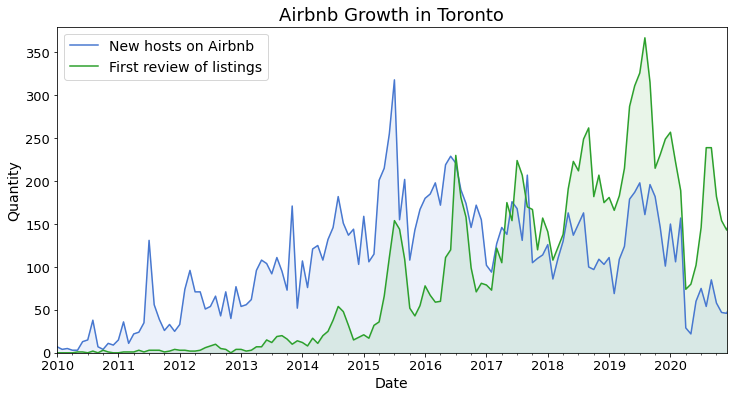

In [73]:
# Nota para queda signfiicativa em 2020 (Pandemia) 
# Notice how theres a significant decrease in 2020 (Covid Pandemic)

# Customizing titles, labels, font sizes
title='Airbnb Growth in Toronto'
xlabel='Date'
ylabel='Quantity'
title_fsize=18
label_fsize=14
tick_fsize=13
legend_fsize=14

plt.figure(figsize=(12,6))
ax = df.set_index('host_since').resample('M').size().plot(label='New hosts on Airbnb', color=sns.color_palette("muted"))
ax = df.set_index('first_review').resample('M').size().plot(label='First review of listings', color=sns.color_palette("tab10")[2])

# Vamos limitar de 2010 a 2020, pulando o começo de 2021 para melhorar a visualização
# Limiting the chart data from 2010-2020, skipping early 2021 to improve visualization
plt.xlim('2010-01-01', '2020-12-30') 
plt.ylim(0, 380) 

# Adding shading
l1 = ax.lines[0]
l2 = ax.lines[1]
x1 = l1.get_xydata()[:,0]
y1 = l1.get_xydata()[:,1]
x2 = l2.get_xydata()[:,0]
y2 = l2.get_xydata()[:,1]
ax.fill_between(x1,y1, color=sns.color_palette("muted"), alpha=0.1)
ax.fill_between(x2,y2, color=sns.color_palette("tab10")[2], alpha=0.1)

plt.title(title, fontsize=title_fsize)
plt.xlabel(xlabel, fontsize=label_fsize)
plt.ylabel(ylabel, fontsize=label_fsize)
plt.xticks(fontsize=tick_fsize)
plt.yticks(fontsize=tick_fsize)

plt.legend(fontsize=legend_fsize)

plt.show()

#ax.figure.savefig(final_figures+"cresc_airbnb.jpeg",format='jpeg', dpi=300, bbox_inches='tight')

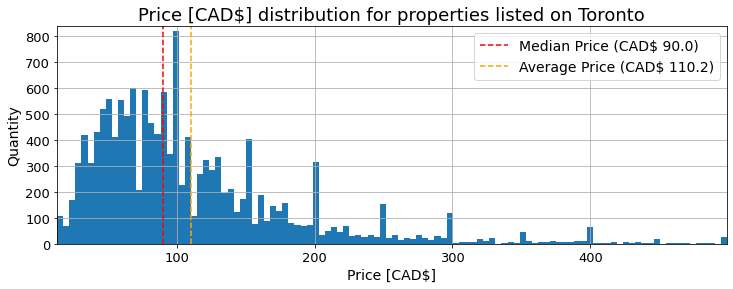

In [74]:
# Customizing titles, labels, font sizes
title='Price [CAD$] distribution for properties listed on Toronto'
xlabel='Price [CAD$]'
ylabel='Quantity'
title_fsize=18
label_fsize=14
tick_fsize=13
legend_fsize=14

plt.figure(figsize=(12,4))
df['price'].hist(bins=110)
plt.margins(x=0, y=0.02)

plt.axvline(median_price, color='red'   , linestyle='--', label='Median Price (CAD$ '+str(median_price)+')')
plt.axvline(mean_price  , color='orange', linestyle='--', label='Average Price (CAD$ '+str(mean_price)+')')


plt.title(title, fontsize=title_fsize)
plt.xlabel(xlabel, fontsize=label_fsize)
plt.ylabel(ylabel, fontsize=label_fsize)
plt.xticks(fontsize=tick_fsize)
plt.yticks(fontsize=tick_fsize)

plt.legend(fontsize=legend_fsize)

#plt.savefig(final_figures+"diaria.jpeg",format='jpeg', dpi=300, bbox_inches='tight')

plt.show()

## Host Analysis

### Amount of Listings / Properties

In [75]:
## Host with most listings
df['host_id'].value_counts().head(10)

top_host_df=pd.DataFrame()
top_host_df=pd.DataFrame(df['host_id'].value_counts().head(10))
top_host_df.reset_index(inplace=True)
top_host_df.rename(columns={'index':'host_id', 'host_id':'listing_count'}, inplace=True)
top_host_df = top_host_df.sort_values(["listing_count"]).reset_index(drop=True)
print(top_host_df)

plot_order = top_host_df.groupby('host_id')['listing_count'].sum().sort_values(ascending=False).index.values
#plot_order

     host_id  listing_count
0  301014754             30
1   26743967             30
2  327456656             36
3  135718015             37
4     846505             47
5     785826             50
6  293274089             54
7  152088065             58
8    1919294             64
9   10202618             69


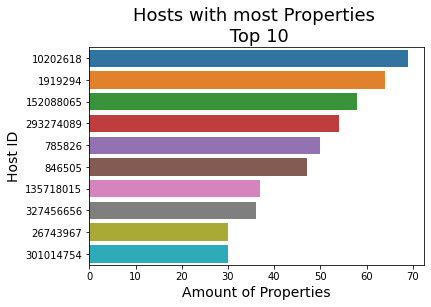

In [76]:
# Customizing titles, labels, font sizes
title = 'Hosts with most Properties \n Top 10'
xlabel = 'Amount of Properties'
ylabel = 'Host ID'
title_fsize=18
label_fsize=14
tick_fsize=10

sns.barplot(y="host_id", x="listing_count", data=top_host_df, orient='h', order = plot_order);

plt.title(title, fontsize=title_fsize);
plt.xlabel(xlabel, fontsize=label_fsize);
plt.ylabel(ylabel, fontsize=label_fsize);
plt.xticks(fontsize=tick_fsize);
plt.yticks(fontsize=tick_fsize);

#plt.savefig(final_figures+"most_prop_host.jpeg",format='jpeg', dpi=300, bbox_inches='tight')

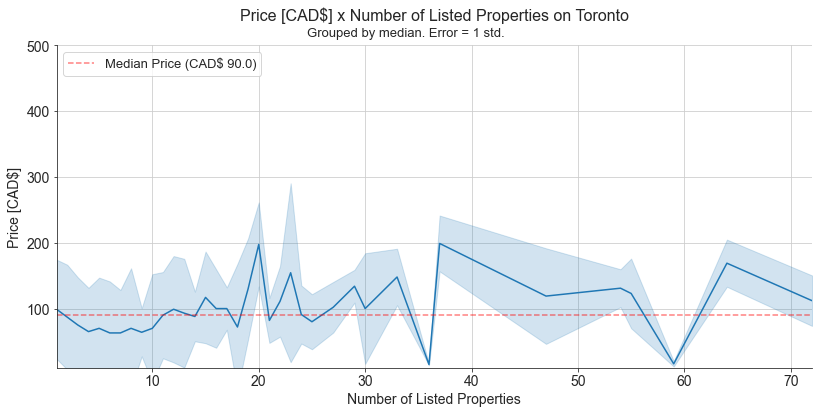

In [77]:
# Customizing titles, labels, font sizes
title='Price [CAD$] x Number of Listed Properties on Toronto'
subtitle='Grouped by median. Error = 1 std.'
xlabel='Number of Listed Properties'
ylabel='Price [CAD$]'
title_fsize=16
subtitle_fsize=13
label_fsize=14
tick_fsize=14
legend_fsize=13


sns.set_style("ticks")
g = sns.relplot(x='calculated_host_listings_count', y='price', data=df, estimator='median', kind="line", ci="sd", ax=ax).set(xlim=(1,72), ylim=(10,500) )
plt.axhline(median_price, color='red', linestyle='--', label='Median Price (CAD$ '+str(median_price)+')', alpha = 0.5)
g.fig.set_size_inches(12,5)

plt.suptitle(subtitle, fontsize=subtitle_fsize, y=1.02)
plt.title(title, fontsize=title_fsize, y=1.06)
plt.xlabel(xlabel, fontsize=label_fsize)
plt.ylabel(ylabel, fontsize=label_fsize)
plt.xticks(fontsize=tick_fsize)
plt.yticks(fontsize=tick_fsize)

plt.legend(loc='upper left', fontsize=legend_fsize)

#plt.savefig(final_figures+"price_per_prop.jpeg",format='jpeg', dpi=300, bbox_inches='tight')


plt.grid()


### Superhost analysis

0.0    0.71
1.0    0.29
Name: host_is_superhost, dtype: float64


Text(0.5, 0, '')

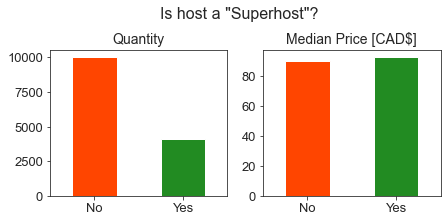

In [78]:
# Customizing titles, labels, font sizes
title = 'Is host a "Superhost"?'
ax1title = 'Quantity'
ax2title = 'Median Price [CAD$]'
title_fsize=16
subtitle_fsize=14
label_fsize=14
tick_fsize=13

xlabel = ['No', "Yes"]
colors = ['orangered', 'forestgreen']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7,3))

print(df['host_is_superhost'].value_counts(normalize=True).round(2))

fig.suptitle(title, fontsize=title_fsize, y=1)
plt.subplots_adjust(top=0.8)

df.groupby('host_is_superhost').size().plot(kind='bar', ax=ax1, color=colors)
df.groupby('host_is_superhost')['price'].median().plot(kind='bar', ax=ax2, color=colors)
ax1.set_xticklabels(labels=xlabel, rotation=0, fontsize=label_fsize)
ax2.set_xticklabels(labels=xlabel, rotation=0, fontsize=label_fsize)
ax1.tick_params(labelsize=tick_fsize)
ax2.tick_params(labelsize=tick_fsize)
ax1.set_title(ax1title, fontsize=subtitle_fsize)
ax2.set_title(ax2title, fontsize=subtitle_fsize)
ax1.set_xlabel('')
ax2.set_xlabel('')    

#fig.savefig(final_figures+"is_superhost.jpeg",format='jpeg', dpi=300, bbox_inches='tight')    

1.0    0.83
0.0    0.17
Name: host_identity_verified, dtype: float64
host_identity_verified
0.0    80.0
1.0    93.0
Name: price, dtype: float64


Text(0.5, 0, '')

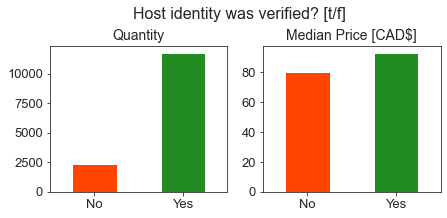

In [79]:
# Customizing titles, labels, font sizes
title = 'Host identity was verified? [t/f]'
ax1title = 'Quantity'
ax2title = 'Median Price [CAD$]'
title_fsize=16
subtitle_fsize=14
label_fsize=14
tick_fsize=13

print(df['host_identity_verified'].value_counts(normalize=True).round(2))
print(df.groupby('host_identity_verified')['price'].median())
xlabel = ['No', 'Yes']
colors = ['orangered', 'forestgreen']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7,3))

fig.suptitle(title, fontsize=title_fsize)
plt.subplots_adjust(top=0.8)

df.groupby('host_identity_verified').size().plot(kind='bar', ax=ax1, color=colors)
df.groupby('host_identity_verified')['price'].median().plot(kind='bar', ax=ax2, color=colors)
ax1.set_xticklabels(labels=xlabel, rotation=0, fontsize=label_fsize)
ax2.set_xticklabels(labels=xlabel, rotation=0, fontsize=label_fsize)
ax1.tick_params(labelsize=tick_fsize)
ax2.tick_params(labelsize=tick_fsize)
ax1.set_title(ax1title, fontsize=subtitle_fsize)
ax2.set_title(ax2title, fontsize=subtitle_fsize)
ax1.set_xlabel('')
ax2.set_xlabel('')

#fig.savefig(final_figures+"is_verified.jpeg",format='jpeg', dpi=300, bbox_inches='tight')

## Geolocalization

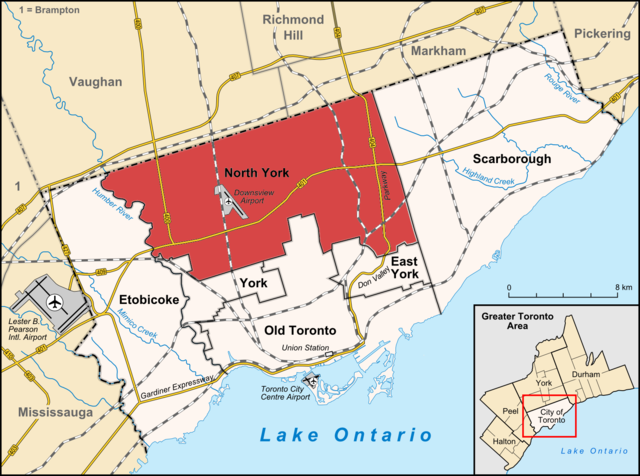

In [80]:
## List of Neighbourhoods (Fonte: Wikipedia / https://en.wikipedia.org/wiki/File:North_York_Locator.png)
display.Image("https://upload.wikimedia.org/wikipedia/commons/thumb/1/15/North_York_Locator.png/640px-North_York_Locator.png")

In [81]:
# Seeing, geographically, properties for latitude and longitude
# Creating an unique list with latitude and longitudes
locations = list(zip(df['latitude'].tolist(), df['longitude'].tolist()))

# Generating a new interactive map (folium lib) with number of properties
properties_count_map = folium.Map(location=[43.70, -79.31], zoom_start=11.45)
FastMarkerCluster(data=locations).add_to(properties_count_map)

properties_count_map

In [82]:
# Creating a heat-map with alternative visualization
from folium.plugins import HeatMap
properties_count_map = folium.Map(location=[43.70, -79.31], zoom_start=11.45)

HeatMap(df[['latitude','longitude']].dropna(),radius=7,gradient={0.2:'blue',0.4:'purple',0.6:'orange',1.0:'red'}).add_to(properties_count_map)

properties_count_map


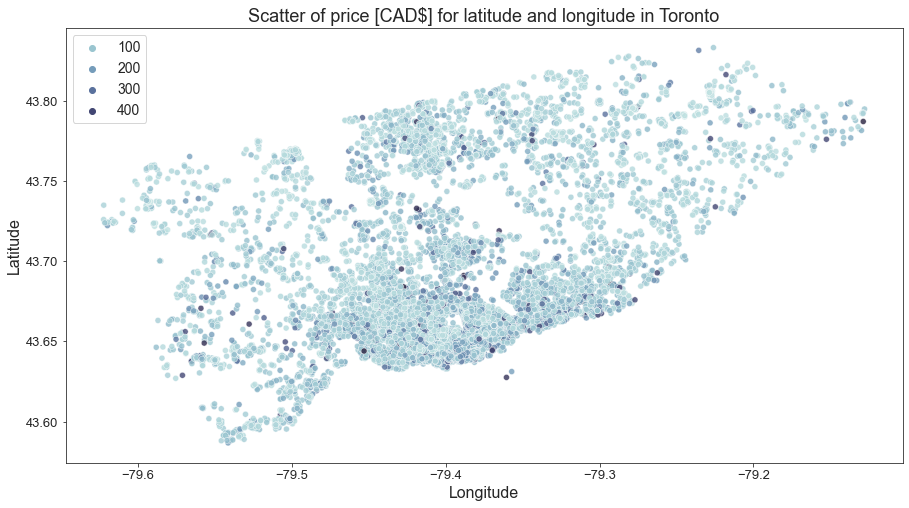

In [83]:
# Customizing titles, labels, font sizes
title = 'Scatter of price [CAD$] for latitude and longitude in Toronto';
xlabel = 'Longitude';
ylabel = 'Latitude';
title_fsize=18
label_fsize=16
tick_fsize=13
legend_fsize=14

plt.figure(figsize = (15,8))
cmap = sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True)
ax = sns.scatterplot(data=df, x='longitude', y='latitude', hue='price', palette=cmap, alpha=0.8)

plt.title(title, fontsize=title_fsize)
plt.xlabel(xlabel, fontsize=label_fsize)
plt.ylabel(ylabel, fontsize=label_fsize)
plt.xticks(fontsize=tick_fsize)
plt.yticks(fontsize=tick_fsize)

plt.legend(fontsize=legend_fsize)

plt.show()

#ax.figure.savefig(final_figures+"price_per_lat_lon.jpeg",format='jpeg', dpi=300, bbox_inches='tight')

In [84]:
price_list_by_n=[]

for x in range(0,len(df['geo_city'].unique())):
    sub_df=df.loc[df['geo_city'] == df["geo_city"].unique()[x]]
    price_sub_df=sub_df[['price']]
    price_list_by_n.append(price_sub_df)

# Creating an empty list that we will append later with price distributions for each neighbourhood_group
# Creating a for loop to get statistics for price ranges and append it to our empty list
stat_df=[]
for x in price_list_by_n:
    i=x.describe(percentiles=[.25, .50, .75])
    i=i.iloc[3:]
    i.reset_index(inplace=True)
    i.rename(columns={'index':'Estatística'}, inplace=True)
    stat_df.append(i)

# Changing names of the price column to the area name for easier reading of the table    
for x in range(0,len(df['geo_city'].unique())):
    stat_df[x].rename(columns={'price':df["geo_city"].unique()[x]}, inplace=True)

# Finalizing our dataframe
stat_df=[df.set_index('Estatística') for df in stat_df]
stat_df=stat_df[0].join(stat_df[1:])
stat_df

,Old Toronto,York,Scarborough,East York,Etobicoke,North York
Estatística,,,,,,
min,13.0,14.0,13.0,15.0,15.00,13.00
25%,70.0,43.0,41.0,50.0,48.00,40.00
50%,100.0,65.0,60.0,74.0,75.00,64.00
75%,150.0,89.5,87.0,103.5,108.25,101.75
max,499.0,495.0,499.0,449.0,499.00,499.00


Old Toronto    0.715830
North York     0.124240
Scarborough    0.066784
Etobicoke      0.043251
York           0.032721
East York      0.017173
Name: geo_city, dtype: float64


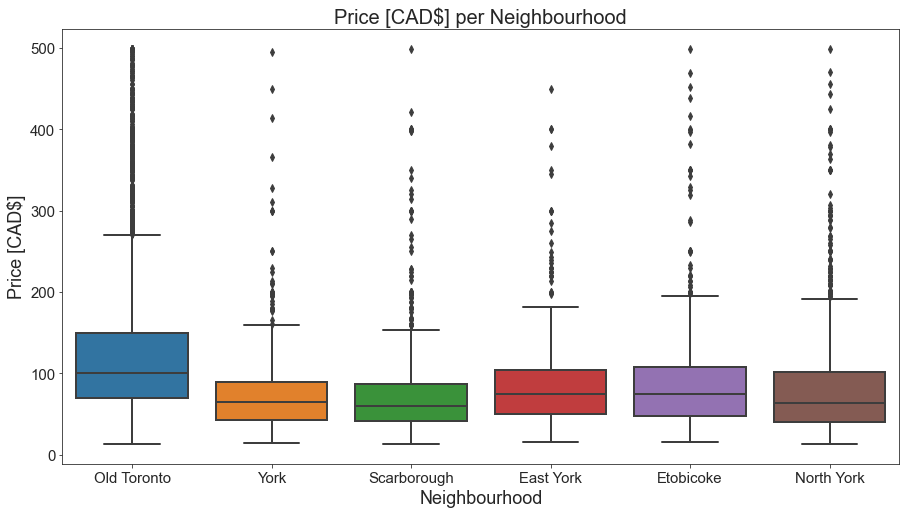

In [85]:
## Price per neighbourhood
## It's no surprise that Old Toronto is, by far, a more touristic neighbourhood than the others. Therefore, it makes sense that the values are also higher.
## It's also interesting to see that 71% of all properties are in Toronto, 12% in North York, and the other 16% distributed in the last 4 neighbourhoods.
## That partially explains why its so beneficial for us to create the clusters.

# Customizing titles, labels, font sizes
title= 'Price [CAD$] per Neighbourhood'
xlabel='Neighbourhood'
ylabel='Price [CAD$]'
title_fsize=20
label_fsize=18
tick_fsize=15

plt.figure(figsize = (15,8))

x = 'geo_city'
y = 'price'
ax = sns.boxplot(x=x, y=y, data=df, linewidth = 2)

plt.title(title, fontsize=title_fsize)
plt.xlabel(xlabel, fontsize=label_fsize)
plt.ylabel(ylabel, fontsize=label_fsize)
plt.xticks(fontsize=tick_fsize)
plt.yticks(fontsize=tick_fsize)


#ax.figure.savefig(final_figures+"price_per_city.jpeg",format='jpeg', dpi=300, bbox_inches='tight')

print(df[x].value_counts(normalize=True))
   
plt.show()

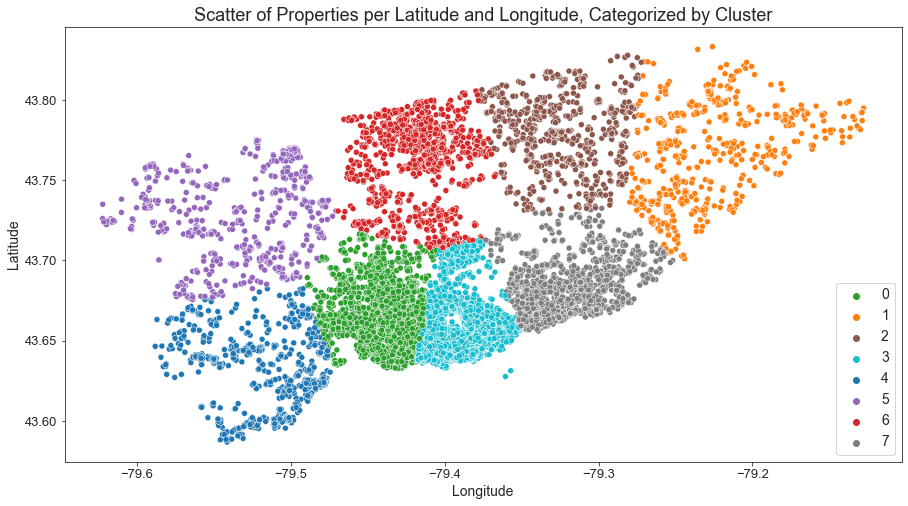

In [86]:
# Customizing titles, labels, font sizes
title= 'Scatter of Properties per Latitude and Longitude, Categorized by Cluster'
xlabel='Longitude'
ylabel='Latitude'
title_fsize=18
label_fsize=14
tick_fsize=13
legend_fsize=14

plt.figure(figsize = (15,8))

color_palette=['tab:green','tab:orange','tab:brown','tab:cyan','tab:blue', 'tab:purple','tab:red','tab:gray']
ax = sns.scatterplot(data=df, x='longitude', y='latitude', hue='geo_cluster', palette=color_palette)

plt.title(title, fontsize=title_fsize)
plt.xlabel(xlabel, fontsize=label_fsize)
plt.ylabel(ylabel, fontsize=label_fsize)
plt.xticks(fontsize=tick_fsize)
plt.yticks(fontsize=tick_fsize)

plt.legend(fontsize=legend_fsize, loc='lower right')

#ax.figure.savefig(final_figures+"scatter_cluster.jpeg",format='jpeg', dpi=300, bbox_inches='tight')

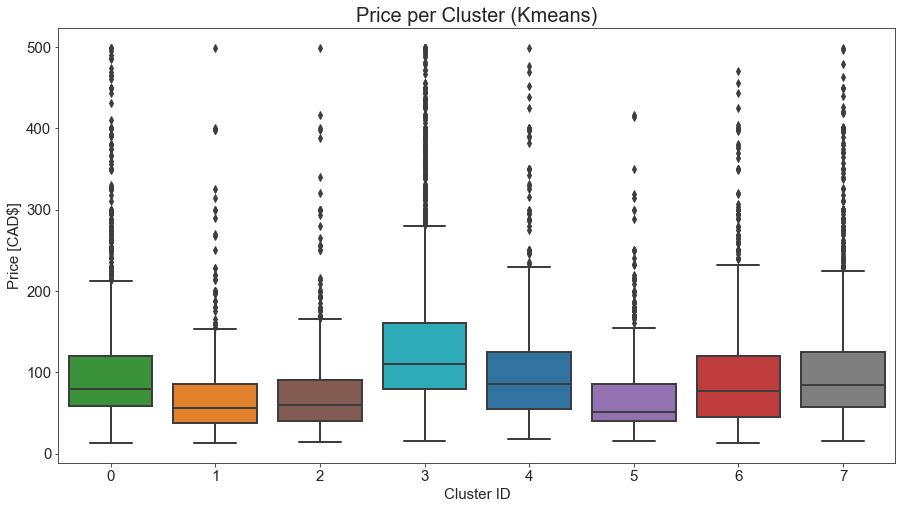

In [87]:
## This shows, clearly, how clusters allows for a better segregation of data.
## And, once again, we can confirm the higher values in Old Toronto (3, 1).
## Note that the colors are the same as the scatter plot.

# Customizing titles, labels, font sizes
title='Price per Cluster (Kmeans)'
xlabel='Cluster ID'
ylabel='Price [CAD$]'
title_fsize=20
label_fsize=15
tick_fsize=15

plt.figure(figsize = (15,8))

x = 'geo_cluster'
y = 'price'
ax = sns.boxplot(x=x, y=y, data=df, linewidth = 2, palette=color_palette)

plt.title(title, fontsize=title_fsize)
plt.xlabel(xlabel, fontsize=label_fsize)
plt.ylabel(ylabel, fontsize=label_fsize)
plt.xticks(fontsize=tick_fsize)
plt.yticks(fontsize=tick_fsize)

#ax.figure.savefig(final_figures+"boxplot_cluster.jpeg",format='jpeg', dpi=300, bbox_inches='tight')
   
plt.show()

## property_type and room_type

Text(0.5, 0, 'Accomodation Type (room_type)')

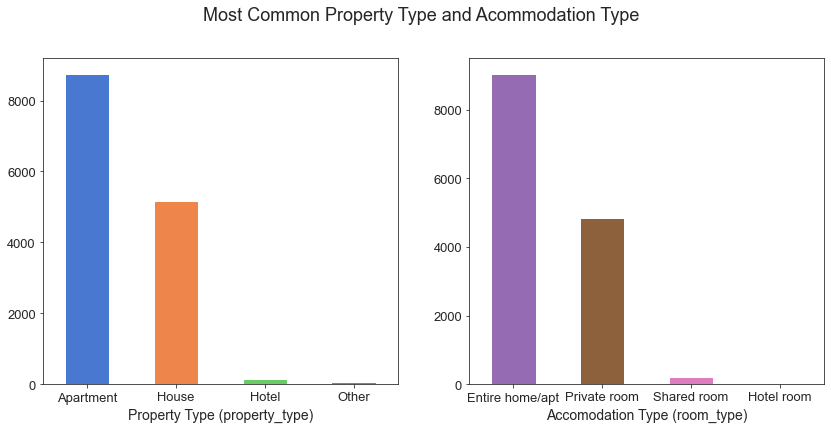

In [88]:
## The vast majority of properties are Apartments, followed by houses. Hotels and others are fairly uncommon.
## The most common room_type is Entire Home/Apt, followed by private rooms. Its fairly uncommon to have shared rooms or hotels, as well.

# Customizing titles, labels, font sizes
title='Most Common Property Type and Acommodation Type'
xlabel='Property Type (property_type)'
ylabel='Accomodation Type (room_type)'
title_fsize=18
label_fsize=14
tick_fsize=13

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
df.groupby("property_type").size().sort_values(ascending=False).plot(kind='bar', ax=ax1, rot = 0, fontsize = 13, color=sns.color_palette("muted"))
df.groupby("room_type").size().sort_values(ascending=False).plot(kind='bar', ax=ax2, rot = 0, fontsize = 13, color=sns.color_palette("muted")[4:])

fig.suptitle(title, fontsize=title_fsize, y=1)
            
ax1.set_xlabel(xlabel, fontsize = label_fsize)
ax2.set_xlabel(ylabel, fontsize = label_fsize)

#ax.figure.savefig(final_figures+"boxplot_cluster.jpeg",format='jpeg', dpi=300, bbox_inches='tight')
#fig.savefig(final_figures+"Tipos_prop.jpeg",format='jpeg', dpi=300, bbox_inches='tight')

In [89]:
# It is a bit unexpected to see that, in fact, the proportions of data is not the same for different neighbourhoods.
# Old toronto has more Entire home/apt, but thats not the same for the other neighbourhoods, Scarborough has more private rooms than Entire home/apt, for example.
ax = sns.catplot(x='geo_city', col='room_type', data=df, kind='count', col_wrap=2)
ax.set_xticklabels(rotation=15, fontsize=12)
ax.fig.suptitle('Types of accomodation ("room_type") for different neighbourhoods', fontsize=18, y = 1.03)

axes = ax.axes.flatten()

axes[0].set_title('Entire home/apt', fontsize=14)
axes[1].set_title('Private room' , fontsize=14)
axes[2].set_title('Shared room' , fontsize=14)
axes[3].set_title('Hotel room' , fontsize=14)
axes[0].set_ylabel('Quantity', fontsize=14)
axes[2].set_ylabel('Quantity', fontsize=14)

for i in range(2,len(axes)):
    axes[i].set_xlabel('Neighbourhood', fontsize=14)
    
#ax.savefig(final_figures+"Tipos_room_municipio.jpeg",format='jpeg', dpi=300, bbox_inches='tight')

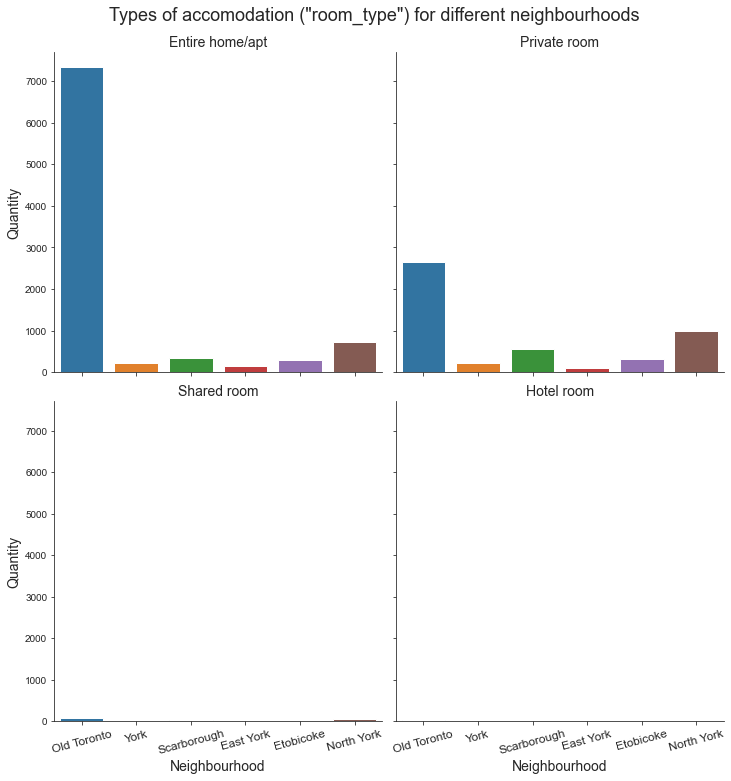

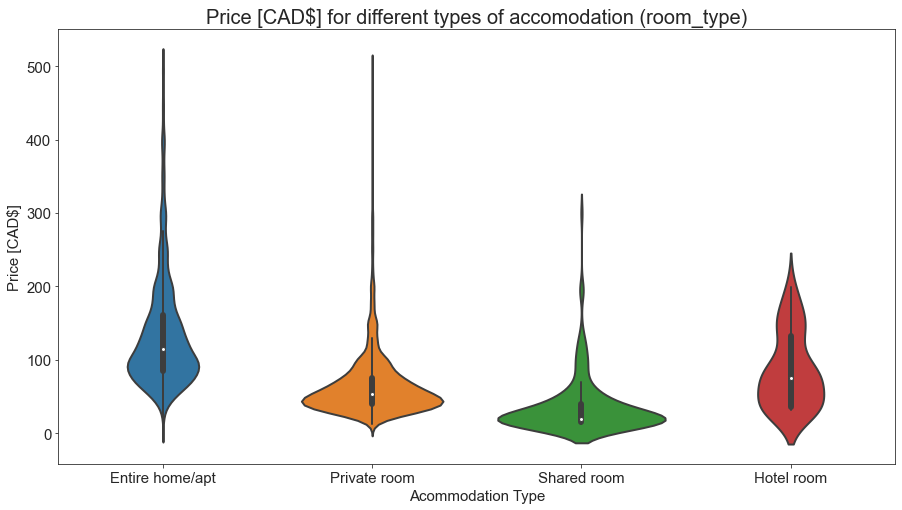

In [90]:
# It's very clear that properties with the entire apartment ("Entire home/apt") have the highest prices. Followed by Private rooms.

# Customizing titles, labels, font sizes
title='Price [CAD$] for different types of accomodation (room_type)'
xlabel='Acommodation Type'
ylabel='Price [CAD$]'
title_fsize=20
label_fsize=15
tick_fsize=15
legend_fsize=15

plt.figure(figsize = (15,8))

x = 'room_type'
y = 'price'
ax = sns.violinplot(x=x, y=y, data=df, linewidth = 2, whis=10, fliersize=3)
ax.axes.set_title(title, fontsize=20)
ax.set_xlabel(xlabel, fontsize=15)
ax.set_ylabel(ylabel, fontsize=15)
ax.tick_params(labelsize=15)

#ax.figure.savefig(final_figures+"Tipos_imovel_preco.jpeg",format='jpeg', dpi=300, bbox_inches='tight')

0    0.7
1    0.3
Name: instant_bookable, dtype: float64
instant_bookable
0    92.0
1    89.0
Name: price, dtype: float64


Text(0.5, 0, '')

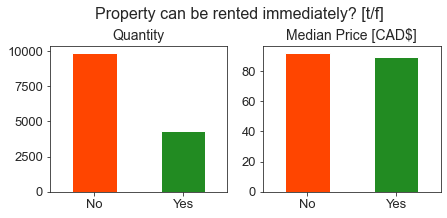

In [91]:
# Customizing titles, labels, font sizes
title =    'Property can be rented immediately? [t/f]'
ax1title = 'Quantity'
ax2title = 'Median Price [CAD$]'
title_fsize=16
subtitle_fsize=14
label_fsize=14
tick_fsize=13

print(df['instant_bookable'].value_counts(normalize=True).round(2))
print(df.groupby('instant_bookable')['price'].median())
xlabel = ['No', 'Yes']
colors = ['orangered', 'forestgreen']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7,3))

fig.suptitle(title, fontsize=title_fsize)
plt.subplots_adjust(top=0.8)

df.groupby('instant_bookable').size().plot(kind='bar', ax=ax1, color=colors)
df.groupby('instant_bookable')['price'].median().plot(kind='bar', ax=ax2, color=colors)
ax1.set_xticklabels(labels=xlabel, rotation=0, fontsize=label_fsize)
ax2.set_xticklabels(labels=xlabel, rotation=0, fontsize=label_fsize)
ax1.tick_params(labelsize=tick_fsize)
ax2.tick_params(labelsize=tick_fsize)
ax1.set_title(ax1title, fontsize=subtitle_fsize)
ax2.set_title(ax2title, fontsize=subtitle_fsize)
ax1.set_xlabel('')
ax2.set_xlabel('')

#fig.savefig(final_figures+"instant_book.jpeg",format='jpeg', dpi=300, bbox_inches='tight')

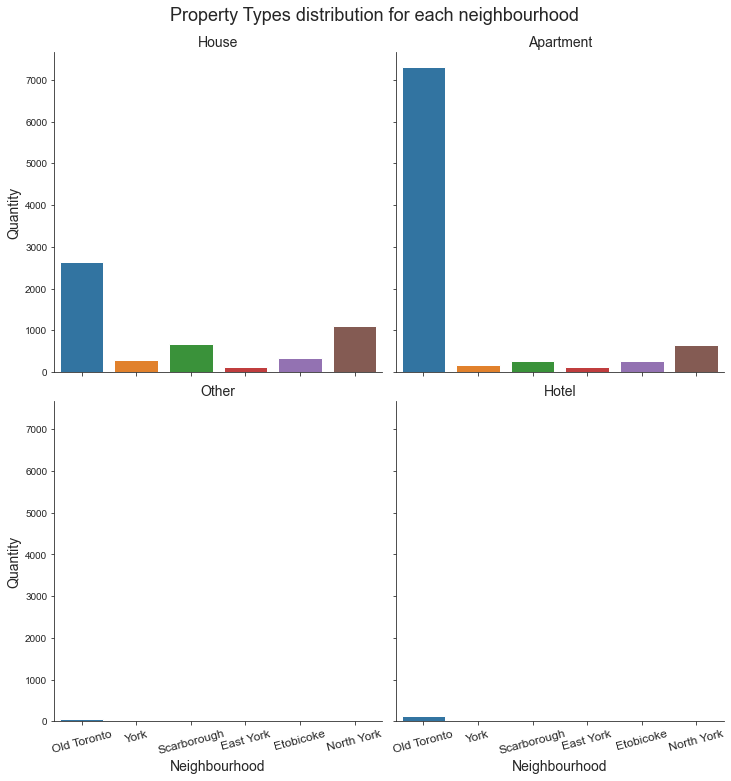

In [92]:
# Here we can see that Old Toronto has many more apartments than the other neighbourhoods. 
# Some other neighbouds, such as Scarborough, has more houses than apartments, reversing the trend.

title='Property Types distribution for each neighbourhood'

ax = sns.catplot(x='geo_city', col='property_type', data=df, kind='count', col_wrap=2)
ax.set_xticklabels(rotation=15, fontsize=12)
ax.fig.suptitle(title, fontsize=18, y = 1.03)

axes = ax.axes.flatten()

axes[0].set_title('House', fontsize=14)
axes[1].set_title('Apartment' , fontsize=14)
axes[2].set_title('Other' , fontsize=14)
axes[3].set_title('Hotel' , fontsize=14)
axes[0].set_ylabel('Quantity', fontsize=14)
axes[2].set_ylabel('Quantity', fontsize=14)

for i in range(2, len(axes)):
    axes[i].set_xlabel('Neighbourhood', fontsize=14)
    
#ax.savefig(final_figures+"Tipos_prop_municipio.jpeg",format='jpeg', dpi=300, bbox_inches='tight')

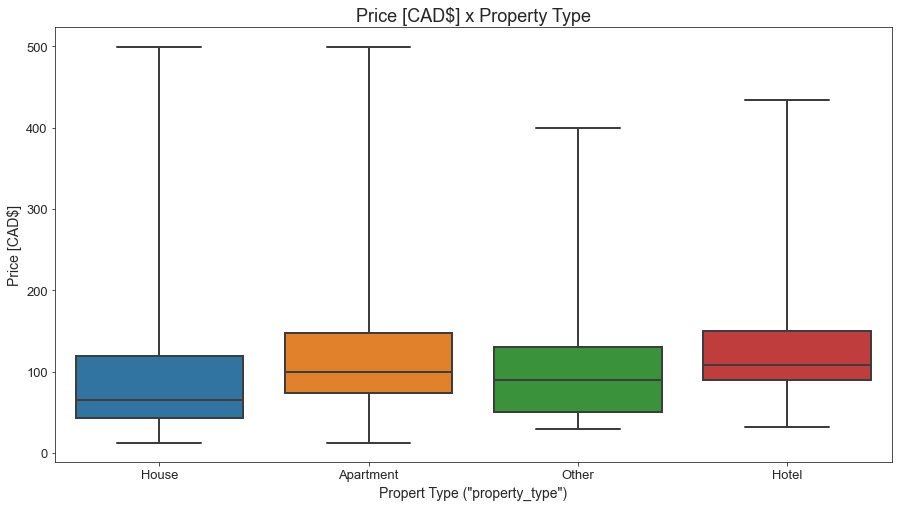

In [93]:
# Customizing titles, labels, font sizes
title='Price [CAD$] x Property Type'
xlabel='Propert Type ("property_type")'
ylabel='Price [CAD$]'
title_fsize=18
label_fsize=14
tick_fsize=13
legend_fsize=14

# Results are fairly similar, but it's still clear that apartments and hotels have the highest median prices.

plt.figure(figsize = (15,8))

x = 'property_type'
y = 'price'
ax = sns.boxplot(x=x, y=y, data=df, linewidth = 2, whis=10, fliersize=3)
plt.title(title, fontsize=title_fsize);
plt.xlabel(xlabel, fontsize=label_fsize);
plt.ylabel(ylabel, fontsize=label_fsize);
plt.xticks(fontsize=tick_fsize);
plt.yticks(fontsize=tick_fsize);

#ax.figure.savefig(final_figures+"Tipos_prop_preco.jpeg",format='jpeg', dpi=300, bbox_inches='tight')

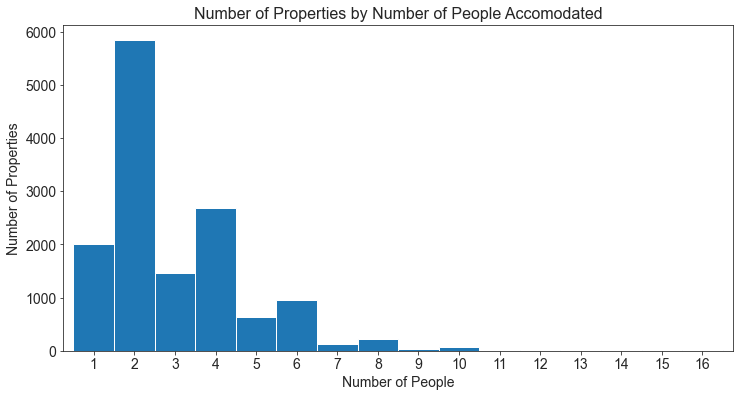

In [94]:
# Customizing titles, labels, font sizes
title='Number of Properties by Number of People Accomodated'
xlabel='Number of People'
ylabel='Number of Properties'
title_fsize=16
label_fsize=14
tick_fsize=14
legend_fsize=13

feq = df['accommodates'].value_counts().sort_index()
ax=feq.plot.bar(figsize=(12,6), width=1, rot=0)
plt.title(title, fontsize=title_fsize)
plt.xlabel(xlabel, fontsize=label_fsize)
plt.ylabel(ylabel, fontsize=label_fsize)
plt.xticks(fontsize=tick_fsize)
plt.yticks(fontsize=tick_fsize)

plt.show()

#ax.figure.savefig(final_figures+"Prop_por_acomm.jpeg",format='jpeg', dpi=300, bbox_inches='tight')

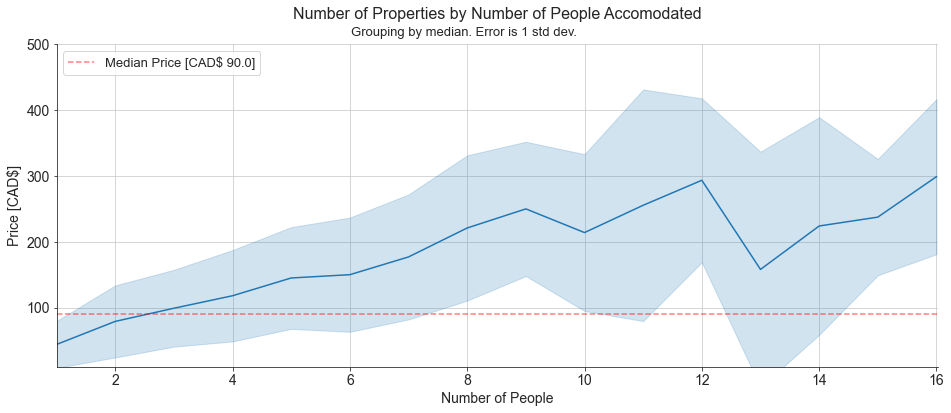

In [95]:
# Customizing titles, labels, font sizes
subtitle='Grouping by median. Error is 1 std dev.'
xlabel='Number of People'
ylabel='Price [CAD$]'
title_fsize=16
subtitle_fsize=13
label_fsize=14
tick_fsize=14
legend_fsize=13

sns.set_style("ticks")
g = sns.relplot(x='accommodates', y='price', data=df, estimator='median', kind="line", ci="sd", ax=ax).set(xlim=(1,16.025), ylim=(10,500) )
plt.axhline(median_price, color='red', linestyle='--', label='Median Price [CAD$ '+str(median_price)+']', alpha = 0.5)
g.fig.set_size_inches(14,5)

plt.suptitle(subtitle, fontsize=subtitle_fsize, y=1.02)
plt.title(title, fontsize=title_fsize, y=1.06)
plt.xlabel(xlabel, fontsize=label_fsize)
plt.ylabel(ylabel, fontsize=label_fsize)
plt.xticks(fontsize=tick_fsize)
plt.yticks(fontsize=tick_fsize)

plt.legend(loc='upper left', fontsize=legend_fsize)

plt.grid()

#g.savefig(final_figures+"Preço_por_acomm.jpeg",format='jpeg', dpi=300, bbox_inches='tight')

In [96]:
## More people = Higher absolute price. HOWEVER! The price per person constantly decreases.
## In other words, even though the absolute price increases, its cheaper for each individu-
## al to be travelling in a big group.

price_per_acc = df.groupby('accommodates')['price'].median().sort_values(ascending=True)                                        
print(price_per_acc)

accommodates
1      44.0
2      79.0
3      99.0
4     118.0
5     145.0
6     150.0
13    158.0
7     177.0
10    214.0
8     221.0
14    224.0
15    237.5
9     250.0
11    255.5
12    293.5
16    299.0
Name: price, dtype: float64


Out of 43 amenities, only 7 have a significant impact of 15% or more on the price


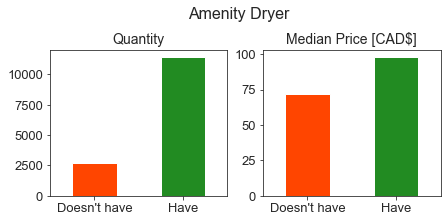

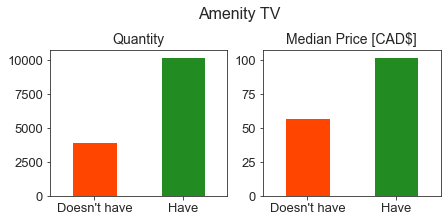

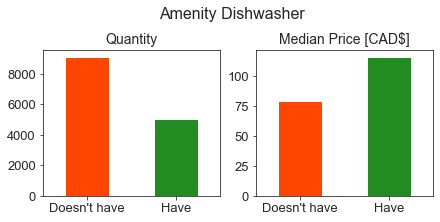

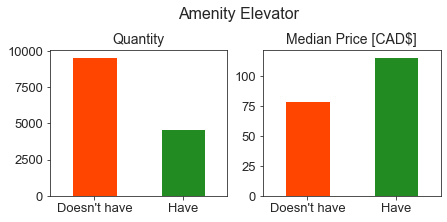

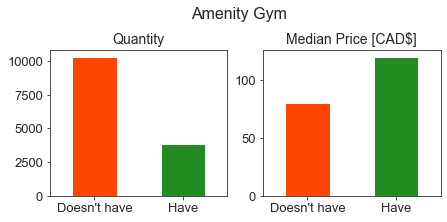

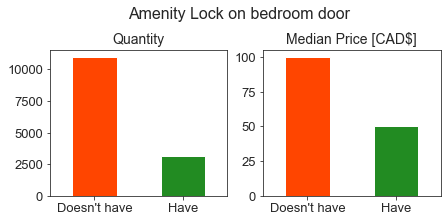

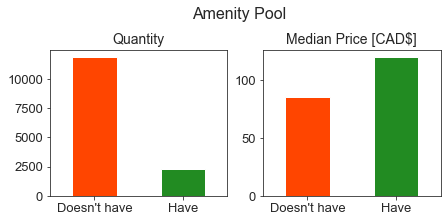

In [97]:
# Customizing titles, labels, font sizes

ax1title = 'Quantity'
ax2title = 'Median Price [CAD$]'
title_fsize=16
subtitle_fsize=14
label_fsize=14
tick_fsize=13

#print(df.columns)
plot_variables=[]
plot_variables = list(df.columns[df.columns.str.startswith("am_") == True])
xlabel = ['Doesn\'t have', "Have"]
colors = ['orangered', 'forestgreen']

count=0

for col in plot_variables:
    if (abs(df.groupby(col)['price'].median()[0]-df.groupby(col)['price'].median()[1])/abs(df.groupby(col)['price'].median()[0]+df.groupby(col)['price'].median()[1]))>15/100:
        count=count+1
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7,3))
        
        # Removing "am_" prefix to improve readability
        fig.suptitle("Amenity " + col.replace("am_",""), fontsize=title_fsize, y=1)
        plt.subplots_adjust(top=0.8)
        
        df.groupby(col).size().plot(kind='bar', ax=ax1, color=colors)
        df.groupby(col)['price'].median().plot(kind='bar', ax=ax2, color=colors)        
        ax1.set_xticklabels(labels=xlabel, rotation=0, fontsize=label_fsize)
        ax2.set_xticklabels(labels=xlabel, rotation=0, fontsize=label_fsize)
        ax1.tick_params(labelsize=tick_fsize)
        ax2.tick_params(labelsize=tick_fsize)
        ax1.set_title(ax1title, fontsize=subtitle_fsize)
        ax2.set_title(ax2title, fontsize=subtitle_fsize)
        ax1.set_xlabel('')
        ax2.set_xlabel('')        
        
        #fig.savefig(final_figures+"am"+ col.replace("am_","") +".jpeg",format='jpeg', dpi=300, bbox_inches='tight')

print("Out of " + str(len(plot_variables)) + " amenities, only " + str(count) + ' have a significant impact of 15% or more on the price')

# 4 - Preparing Data for the Model

## Dropping Unused Columns

In [99]:
df = df.drop("host_since", axis=1)   # Dropped, but is being used in host_since_days
df = df.drop("last_review", axis=1)  # Dropped, but is being used in last_review_days
df = df.drop("first_review", axis=1) # Dropped, but is being used in first_review_days

# Useful for exploratory data analysis, but not for the model
df = df.drop("host_id", axis=1)
df = df.drop("geo_city", axis=1)    
df = df.drop("latitude", axis=1)
df = df.drop("longitude", axis=1)

print(df.shape)
print(df.columns)

## Preparing Dummy Variables

In [ ]:
df = pd.get_dummies(df, columns = ['host_response_time','host_response_rate','host_acceptance_rate','property_type','room_type'])  # Host and Property information
df = pd.get_dummies(df, columns = ['first_review_days','last_review_days','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value']) # Reviews
df = pd.get_dummies(df, columns = ['review_polarity']) # NLP
df = pd.get_dummies(df, columns = ['geo_cluster']) # Geolocation
print(df.shape)
print(df.columns)

## Correlation Matrix 

In [ ]:
# Vamos remover as amenities para melhorar a legibilidade. Elas vão ser analisadas em isolamento mais a frente.
sub_df = df.drop(list(df.columns[df.columns.str.startswith('am_')]), axis=1) 
# Vamos remover, também, as áreas segmentadas em clusters.
sub_df = sub_df.drop(list(sub_df.columns[sub_df.columns.str.startswith('geo_')]), axis=1)

sns.set(style="white")
f, ax = plt.subplots(figsize=(20,20))

# Matriz de correlação SEM abs()
corr = sub_df.corr()
# Mascara (mask) precisa ter o mesmo formato de corr
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Cores (Colormap) para o heatmap
cmap = sns.diverging_palette(10, 220, as_cmap=True)

ax = sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.1, cbar_kws={"shrink": .5}, vmax=1.0, vmin=-1.0);

print("Maior correlação é de: "+ str(round(corr[corr != 1.0].max().max(),2)) + ". Já a menor correlação é de: "+ str(round(corr[corr != 1.0].min().min(),2)))

#ax.figure.savefig(final_figures+"corr_matrix.jpeg",format='jpeg', dpi=300, bbox_inches='tight')

## Matriz de Correlação das Amenidades (Amenities)

In [ ]:
# Aqui, vamos analiasr as Ameninades em isolamento
amenities_columns = [col for col in df if col.startswith('am_')]
sub_df = df[amenities_columns]

sns.set(style="white")
f, ax = plt.subplots(figsize=(20,20))

corr = sub_df.corr()
mask = np.zeros_like(corr, dtype=np.bool)

mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(10, 220, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.1, cbar_kws={"shrink": .5}, vmax=1.0, vmin=-1.0);

print("Maior correlação é de: "+ str(round(corr[corr != 1.0].max().max(),2)) + ". Já a menor correlação é de: "+ str(round(corr[corr != 1.0].min().min(),2)))

## As correlações não passam de 0.93, como na matriz completa.
## Mesmo assim vemos alguns casos interessantes, como: Casas com Máquina de secar (Dryer) frequentemente também tem Máquina de lavar (Washer)
## Casas com pratos e talheres (Dishes and Silverware), frequentemente tem geladeiras(Refrigerator)
## Casas com Micro-ondas (Microwave), frequentemente tem geladeiras (Refrigerator)
## Casas com Stove (Fogão), frequentemente tem Oven (Forno)
#ax.figure.savefig(final_figures+"corr_matrix_2.jpeg",format='jpeg', dpi=300, bbox_inches='tight')

In [ ]:
# Como mais a frente vamos utilizar modelos de Random Trees e XGboost, as inter-correlações não são tão críticas.
# Mesmo assim, vamos remover somente as correlações extremas.

# Criar uma matriz de correlação absoluta
corr = df.corr().abs()

# Selecionar o triangulo superior
triangle_upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))

# Filtrar por correlações > 0.99
to_drop = [column for column in triangle_upper.columns if any(triangle_upper[column] > 0.99)]
print(to_drop)
print(len(to_drop))

# Remover (Drop) essas colunas
df.drop(to_drop, axis=1, inplace=True)

In [ ]:
numerical_columns = ['accommodates', 'bathrooms_text', 'bedrooms', 'beds', 'price', 'minimum_nights', 'maximum_nights', 'availability_365',
       'number_of_reviews', 'instant_bookable', 'calculated_host_listings_count', 'reviews_per_month', 'host_since_days']


fig = plt.figure(figsize=(10,18))
for i, var_name in enumerate(numerical_columns):
    #ax = fig.add_subplot(3,3,i+1)
    ax = fig.add_subplot(6,3, i+1)
    df[var_name].hist(bins=10,ax=ax)
    ax.set_title(var_name)
fig.tight_layout()
plt.show()

#fig.savefig(final_figures+"num_before.jpeg",format='jpeg', dpi=300, bbox_inches='tight')

In [ ]:
for col in numerical_columns:
    # Substituindo 0 com 0.01
    df[col] = df[col].astype('float64').replace(0.0, 0.01) 
    # Fazendo transformação logaritimica
    df[col] = np.log(df[col])

In [ ]:
fig = plt.figure(figsize=(10,18))
for i, var_name in enumerate(numerical_columns):
    #ax = fig.add_subplot(3,3,i+1)
    ax = fig.add_subplot(6,3, i+1)
    df[var_name].hist(bins=10,ax=ax)
    ax.set_title(var_name)
fig.tight_layout()
plt.show()

#fig.savefig(final_figures+"num_after.jpeg",format='jpeg', dpi=300, bbox_inches='tight')

In [ ]:
#Confirmando que não temos colunas nulos
df.isna().sum().sum()

In [ ]:
# Separando em X e y
X = df.drop('price', axis=1)
y = df.price

# Scaling
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))

# 5 - Modelos

In [ ]:
# Divisão em teste e treino
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1092867)

In [ ]:
# Performance
def AlgorithmMetrics(y_train, y_test, pred_train, pred_test):
    print("Training MSE: "  + str(round(mean_squared_error(y_train, pred_train),3)) + " | Test MSE: " + str(round(mean_squared_error(y_test, pred_test),3)))
    print("Training R²:  "  + str(round(r2_score(y_train, pred_train),3)) +           "  | Test R²:  " + str(round(r2_score(y_test, pred_test),3)))

## 1 - Random Forest

In [ ]:
# Importar o modelo que vamos utilizar
rf_reg = RandomForestRegressor(n_estimators = 250, max_features='auto')
# Fazer fit no modelo com os dados de treino
rf_reg.fit(X_train, y_train)

# Fazer predições com o modelo
rf_pred_train = rf_reg.predict(X_train)
rf_pred_test  = rf_reg.predict(X_test)

print("Random Forest Algorithm")
AlgorithmMetrics(y_train, y_test, rf_pred_train, rf_pred_test)

## 2 - XGBoost

In [ ]:
xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)
xgb_pred_train = xgb_reg.predict(X_train)
xgb_pred_test = xgb_reg.predict(X_test)

print("XGBoost Algorithm")
AlgorithmMetrics(y_train, y_test, xgb_pred_train, xgb_pred_test)

In [ ]:
ft_weights_xgb_reg = pd.DataFrame(xgb_reg.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights_xgb_reg.sort_values('weight', ascending=False, inplace=True)
#print(ft_weights_xgb_reg.iloc(ft_weights_xgb_reg>5))
pd.set_option('display.max_rows', len(ft_weights_xgb_reg))
ft_weights_xgb_reg.head()

In [ ]:
ft_weights_xgb_reg = pd.DataFrame(xgb_reg.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights_xgb_reg.sort_values('weight', ascending=False, inplace=True)

# Plotting feature importances
plt.figure(figsize=(10,28))
plt.barh(ft_weights_xgb_reg.index, ft_weights_xgb_reg.weight, align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.grid(zorder=0)

#plt.savefig(final_figures+"feat_import_all.jpeg",format='jpeg', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
#print(ft_weights_xgb_reg.loc[ft_weights_xgb_reg['weight'] > 0.005])

# Plotting feature importances
plt.figure(figsize=(6,8))
plt.barh(ft_weights_xgb_reg.loc[ft_weights_xgb_reg['weight'] > 0.005].index, ft_weights_xgb_reg.loc[ft_weights_xgb_reg['weight'] > 0.005].weight, align='center') 
plt.title("Importância dos Atributos para o modelo de XGBoost", fontsize=14)
plt.xlabel("Importância do Atributo")
plt.margins(y=0.01)
plt.grid(zorder=0)

#plt.savefig(final_figures+"feat_import_most_import.jpeg",format='jpeg', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
#Removendo colunas com baixa importância
all_reviews = list(X_train.columns[X_train.columns.str.startswith("review_scores")])
reviews_to_keep1 = list(X_train.columns[X_train.columns.str.startswith("review_scores_location")])
reviews_to_keep2 = list(X_train.columns[X_train.columns.str.startswith("review_scores_cleanliness")])
reviews_to_drop = [x for x in all_reviews if x not in ((reviews_to_keep1) and (reviews_to_keep2))]

all_amenities = list(X_train.columns[X_train.columns.str.startswith("am_")])
amenities_to_keep = ['am_TV','am_Gym','am_Long term stays allowed', 'am_Dishwasher', 'am_Elevator', 'am_Lock on bedroom door']
amenities_to_drop = [x for x in all_amenities if x not in amenities_to_keep]

other_to_drop=['availability_365', 'host_is_superhost', 'number_of_reviews', 'description_polarity', 'beds', 'maximum_nights', 'instant_bookable', 'minimum_nights']


columns_to_drop = amenities_to_drop + reviews_to_drop + other_to_drop
print(len(columns_to_drop))

X_train_short = X_train.drop(columns_to_drop, axis=1)
X_test_short = X_test.drop(columns_to_drop, axis=1)

## 3 - Random Forest 2 (Com Colunas Removidas)

In [ ]:
rf2_reg = RandomForestRegressor(n_estimators = 250, max_features='auto')
rf2_reg.fit(X_train, y_train)

rf2_pred_train = rf2_reg.predict(X_train)
rf2_pred_test = rf2_reg.predict(X_test)

print("Random Forest - 2 Algorithm")
AlgorithmMetrics(y_train, y_test, rf2_pred_train, rf2_pred_test)

## 4 - XGBoost (Com Colunas Removidas)

In [ ]:
xgb2_reg = xgb.XGBRegressor()
xgb2_reg.fit(X_train, y_train)
xgb2_pred_train = xgb2_reg.predict(X_train)
xgb2_pred_test = xgb2_reg.predict(X_test)

print("XGBoost - 2 Algorithm")
AlgorithmMetrics(y_train, y_test, xgb2_pred_train, xgb2_pred_test)x

In [ ]:
print("Tempo de execução: "+ str(round((time.time() - start_time)/60,1)) + " minutos. Última execução em: " + str(datetime.now(tz=None)))